In [1]:
import os
import glob
import pandas as pd

# Directories for new data
stats_dir = '/nas/longleaf/home/adaigle/work/ghist_2024_work/split_hugepriors/split2/stats/'
logs_dir = '/nas/longleaf/home/adaigle/work/ghist_2024_work/split_hugepriors/split2/vcfs/'
plot_dir = '/nas/longleaf/home/adaigle/work/ghist_2024_work/split_hugepriors/split2/plots/'
os.makedirs(plot_dir, exist_ok=True)

# Load the log files with new parameters
log_files = glob.glob(os.path.join(logs_dir, '*.tsv'))
log_data = []
for log_file in log_files:
    repnum = int(os.path.basename(log_file).split('_')[1].split('.')[0])
    log_df = pd.read_csv(log_file, sep='\t', header=None, names=['repnum', 'Nanc', 'Nwest', 'Neast', 'T'])
    log_df['repnum'] = repnum
    log_data.append(log_df)
logs_df = pd.concat(log_data, ignore_index=True)
print('Log data loaded with new parameters.')

# Load the stats files from the new `stats_dir`
stats_files = glob.glob(os.path.join(stats_dir, '*.stats'))
stats_data = []
for stats_file in stats_files:
    repnum = int(os.path.basename(stats_file).split('_')[1].split('.')[0])
    stats_df = pd.read_csv(stats_file, sep='\t')
    stats_df['repnum'] = repnum
    stats_data.append(stats_df)
stats_df = pd.concat(stats_data, ignore_index=True)
print('Stats data from split/stats loaded.')

# Merge stats with logs data on 'repnum' to create the final DataFrame
df = pd.merge(stats_df, logs_df, on='repnum', how='inner')
print('Final DataFrame created.')

# Define parameter and feature columns
parameter_columns = ['Nanc', 'Nwest', 'Neast', 'T']
feature_columns = [col for col in stats_df.columns if col != 'repnum']


Log data loaded with new parameters.
Stats data from split/stats loaded.
Final DataFrame created.


/work/users/a/d/adaigle/.conda/envs/myenv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/10000], Loss: 0.3525, Val Loss: 0.3321
Epoch [20/10000], Loss: 0.1759, Val Loss: 0.1611
Epoch [30/10000], Loss: 0.0607, Val Loss: 0.0579
Epoch [40/10000], Loss: 0.0401, Val Loss: 0.0387
Epoch [50/10000], Loss: 0.0244, Val Loss: 0.0245
Epoch [60/10000], Loss: 0.0191, Val Loss: 0.0188
Epoch [70/10000], Loss: 0.0154, Val Loss: 0.0155
Epoch [80/10000], Loss: 0.0132, Val Loss: 0.0133
Epoch [90/10000], Loss: 0.0118, Val Loss: 0.0119
Epoch [100/10000], Loss: 0.0107, Val Loss: 0.0109
Epoch [110/10000], Loss: 0.0098, Val Loss: 0.0100
Epoch [120/10000], Loss: 0.0091, Val Loss: 0.0093
Epoch [130/10000], Loss: 0.0085, Val Loss: 0.0087
Epoch [140/10000], Loss: 0.0080, Val Loss: 0.0082
Epoch [150/10000], Loss: 0.0075, Val Loss: 0.0078
Epoch [160/10000], Loss: 0.0071, Val Loss: 0.0074
Epoch [170/10000], Loss: 0.0067, Val Loss: 0.0070
Epoch [180/10000], Loss: 0.0064, Val Loss: 0.0067
Epoch [190/10000], Loss: 0.0061, Val Loss: 0.0064
Epoch [200/10000], Loss: 0.0058, Val Loss: 0.0062
Epoch [21

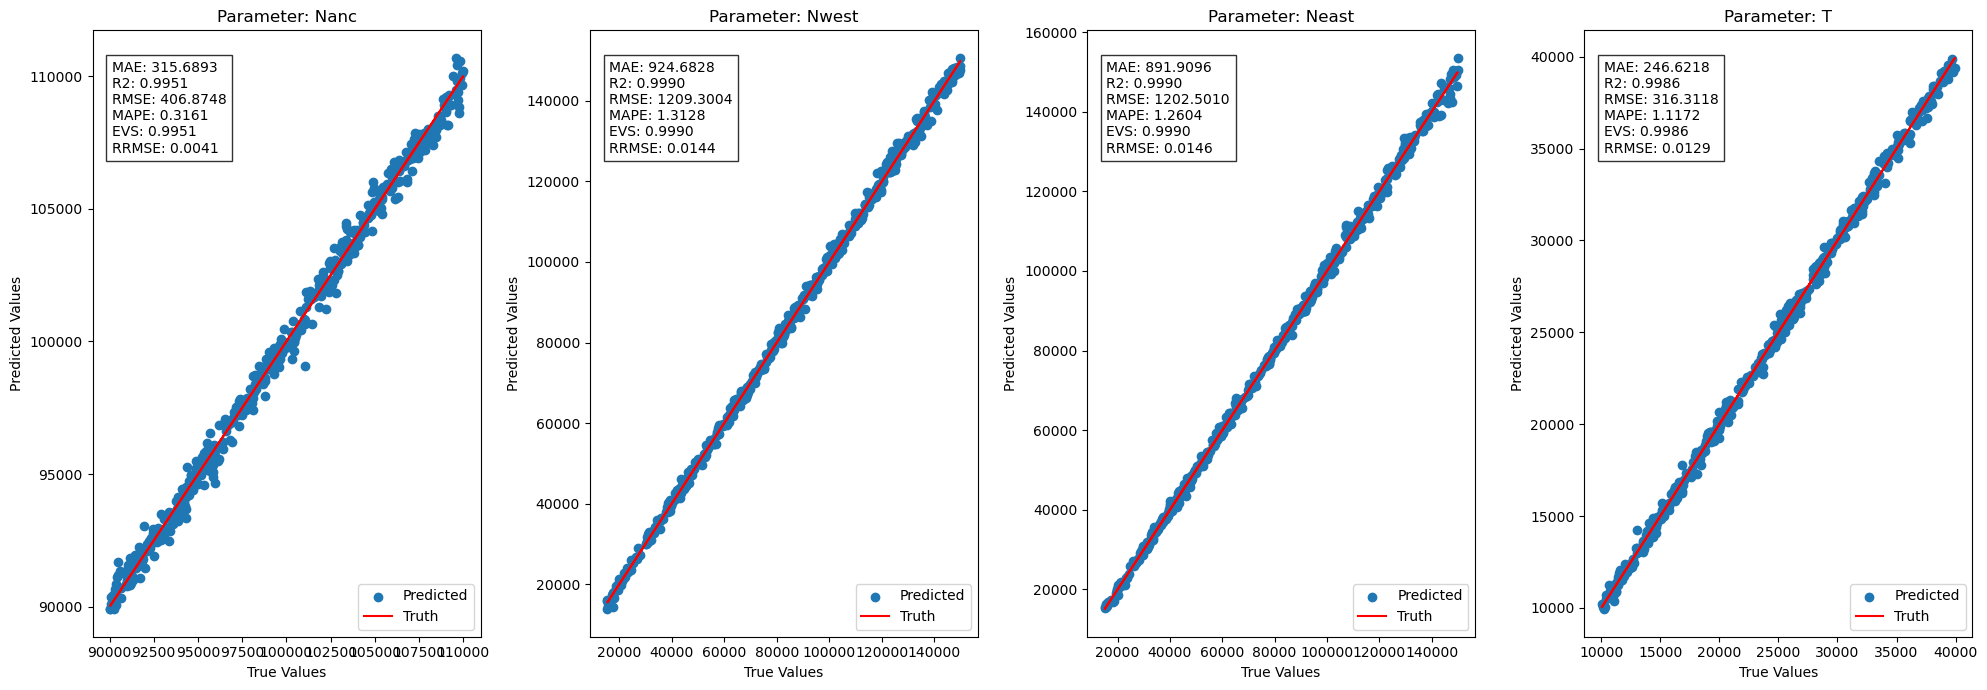

In [2]:
#ORIGINAL MODEL
import os
import glob
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, explained_variance_score
import matplotlib.pyplot as plt
import re

#filtered_feature_columns = [
#    col for col in feature_columns
#    if not (col.startswith("east_sfs_") and int(re.search(r"\d+", col).group()) >= 38)
#]
# Separate the first 100 rows for later prediction
df_first_100 = df.iloc[:500, :]
df_remaining = df.iloc[500:, :]
# Define X and y for the remaining data
X = df_remaining[feature_columns].values
y = df_remaining[parameter_columns].values

# Split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale both features and targets
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)

y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)

# Convert the scaled data to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)

# Define a simplified MLP model similar to the original architecture
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        
        self.hidden1 = nn.Linear(input_size, 128)
        self.hidden2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, output_size)
        self.relu = nn.LeakyReLU(0.01)

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.output(x)
        return x

# Initialize the model
input_size = X_train.shape[1]
output_size = y_train.shape[1]
model = MLP(input_size, output_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler and early stopping
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=10, verbose=True)
early_stopping_patience = 20
best_val_loss = float('inf')
epochs_without_improvement = 0

# Training loop with early stopping and learning rate scheduler
num_epochs = 10000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    # Learning rate scheduler step
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1  # Increment counter if no improvement

    # Stop training if no improvement for `early_stopping_patience` epochs
    if epochs_without_improvement >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch + 1} with validation loss {val_loss:.4f}")
        break

# Predict using the first 1000 rows
X_first_100 = df_first_100[feature_columns].values
X_first_100_scaled = scaler_X.transform(X_first_100)
X_first_100_tensor = torch.tensor(X_first_100_scaled, dtype=torch.float32)

# Make predictions
model.eval()
with torch.no_grad():
    predictions_scaled = model(X_first_100_tensor).numpy()

# Inverse transform the scaled predictions and true values
predictions = scaler_y.inverse_transform(predictions_scaled)
true_values = df_first_100[parameter_columns].values

# Calculate metrics for each target
def compute_metrics(true, pred):
    metrics = []
    for i in range(true.shape[1]):
        mae = mean_absolute_error(true[:, i], pred[:, i])
        rmse = np.sqrt(mean_squared_error(true[:, i], pred[:, i]))
        r2 = r2_score(true[:, i], pred[:, i])
        mape = np.mean(np.abs((true[:, i] - pred[:, i]) / true[:, i])) * 100
        evs = explained_variance_score(true[:, i], pred[:, i])
        rrmse = rmse / np.mean(np.abs(true[:, i]))

        metrics.append({
            "mae": mae,
            "rmse": rmse,
            "r2": r2,
            "mape": mape,
            "evs": evs,
            "rrmse": rrmse
        })
    return metrics

metrics = compute_metrics(true_values, predictions)

# Plot the results
def plot_results(metrics, all_true_values, all_predicted_means, parameter_names):
    num_parameters = len(parameter_names)
    fig, axes = plt.subplots(1, num_parameters, figsize=(5 * num_parameters, 7))
    
    if num_parameters == 1:
        axes = [axes]
    
    for i in range(num_parameters):
        true_values = all_true_values[:, i]
        predicted_values = all_predicted_means[:, i]
        
        axes[i].scatter(true_values, predicted_values, label='Predicted')
        axes[i].plot(true_values, true_values, 'r-', label='Truth')
        axes[i].set_title(f'Parameter: {parameter_names[i]}')
        axes[i].set_xlabel('True Values')
        axes[i].set_ylabel('Predicted Values')
        axes[i].legend(loc='lower right')
        
        # Display metrics
        metrics_text = (
            f'MAE: {metrics[i]["mae"]:.4f}\n'
            f'R2: {metrics[i]["r2"]:.4f}\n'
            f'RMSE: {metrics[i]["rmse"]:.4f}\n'
            f'MAPE: {metrics[i]["mape"]:.4f}\n'
            f'EVS: {metrics[i]["evs"]:.4f}\n'
            f'RRMSE: {metrics[i]["rrmse"]:.4f}'
        )
        axes[i].text(0.05, 0.95, metrics_text, transform=axes[i].transAxes, verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    # Save the plot
    plt.savefig(os.path.join(plot_dir, 'parameter_predictions_mlp.png'))
    plt.show()

parameter_names = parameter_columns
plot_results(metrics, true_values, predictions, parameter_names)

/work/users/a/d/adaigle/.conda/envs/myenv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/10000], Loss: 0.3707, Val Loss: 0.3504
Epoch [20/10000], Loss: 0.1943, Val Loss: 0.1767
Epoch [30/10000], Loss: 0.0820, Val Loss: 0.0738
Epoch [40/10000], Loss: 0.0426, Val Loss: 0.0429
Epoch [50/10000], Loss: 0.0252, Val Loss: 0.0253
Epoch [60/10000], Loss: 0.0194, Val Loss: 0.0192
Epoch [70/10000], Loss: 0.0154, Val Loss: 0.0155
Epoch [80/10000], Loss: 0.0132, Val Loss: 0.0132
Epoch [90/10000], Loss: 0.0118, Val Loss: 0.0119
Epoch [100/10000], Loss: 0.0107, Val Loss: 0.0108
Epoch [110/10000], Loss: 0.0098, Val Loss: 0.0100
Epoch [120/10000], Loss: 0.0091, Val Loss: 0.0093
Epoch [130/10000], Loss: 0.0084, Val Loss: 0.0087
Epoch [140/10000], Loss: 0.0079, Val Loss: 0.0081
Epoch [150/10000], Loss: 0.0074, Val Loss: 0.0077
Epoch [160/10000], Loss: 0.0070, Val Loss: 0.0072
Epoch [170/10000], Loss: 0.0066, Val Loss: 0.0069
Epoch [180/10000], Loss: 0.0062, Val Loss: 0.0065
Epoch [190/10000], Loss: 0.0059, Val Loss: 0.0062
Epoch [200/10000], Loss: 0.0056, Val Loss: 0.0060
Epoch [21

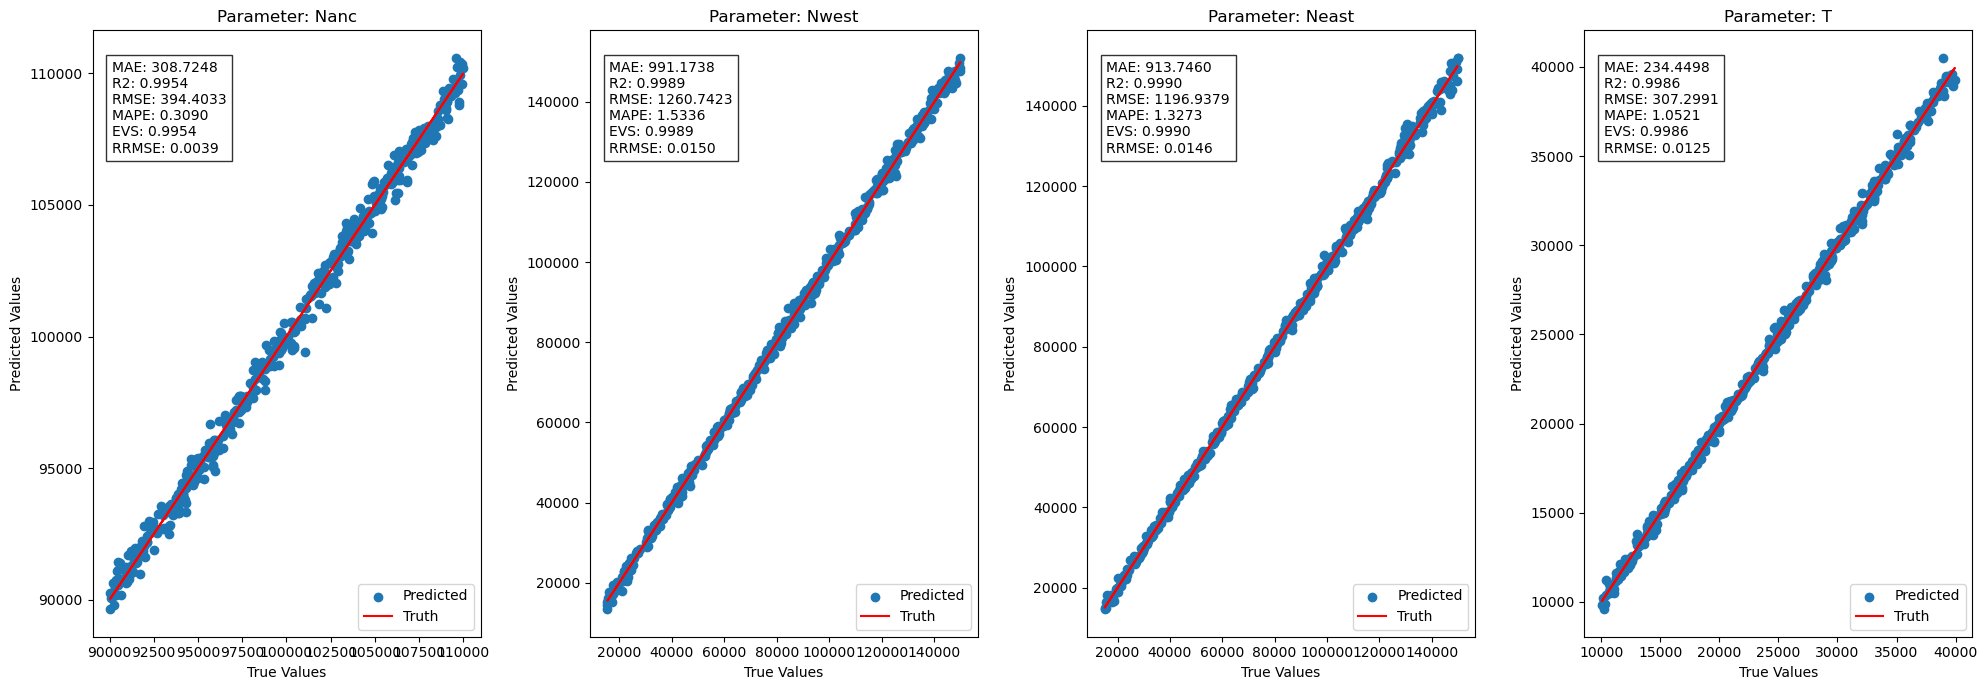

In [3]:
#ORIGINAL MODEL
import os
import glob
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, explained_variance_score
import matplotlib.pyplot as plt
import re

#filtered_feature_columns = [
#    col for col in feature_columns
#    if not (col.startswith("east_sfs_") and int(re.search(r"\d+", col).group()) >= 38)
#]
# Separate the first 100 rows for later prediction
df_first_100 = df.iloc[:500, :]
df_remaining = df.iloc[500:, :]
# Define X and y for the remaining data
X = df_remaining[feature_columns].values
y = df_remaining[parameter_columns].values

# Split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale both features and targets
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)

y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)

# Convert the scaled data to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)

# Define a simplified MLP model similar to the original architecture
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        
        self.hidden1 = nn.Linear(input_size, 128)
        self.hidden2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, output_size)
        self.relu = nn.LeakyReLU(0.01)

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.output(x)
        return x

# Initialize the model
input_size = X_train.shape[1]
output_size = y_train.shape[1]
model = MLP(input_size, output_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler and early stopping
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=10, verbose=True)
early_stopping_patience = 20
best_val_loss = float('inf')
epochs_without_improvement = 0

# Training loop with early stopping and learning rate scheduler
num_epochs = 10000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    # Learning rate scheduler step
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter if validation loss improves
    else:
        epochs_without_improvement += 1  # Increment counter if no improvement

    # Stop training if no improvement for `early_stopping_patience` epochs
    if epochs_without_improvement >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch + 1} with validation loss {val_loss:.4f}")
        break

# Predict using the first 1000 rows
X_first_100 = df_first_100[feature_columns].values
X_first_100_scaled = scaler_X.transform(X_first_100)
X_first_100_tensor = torch.tensor(X_first_100_scaled, dtype=torch.float32)

# Make predictions
model.eval()
with torch.no_grad():
    predictions_scaled = model(X_first_100_tensor).numpy()

# Inverse transform the scaled predictions and true values
predictions = scaler_y.inverse_transform(predictions_scaled)
true_values = df_first_100[parameter_columns].values

# Calculate metrics for each target
def compute_metrics(true, pred):
    metrics = []
    for i in range(true.shape[1]):
        mae = mean_absolute_error(true[:, i], pred[:, i])
        rmse = np.sqrt(mean_squared_error(true[:, i], pred[:, i]))
        r2 = r2_score(true[:, i], pred[:, i])
        mape = np.mean(np.abs((true[:, i] - pred[:, i]) / true[:, i])) * 100
        evs = explained_variance_score(true[:, i], pred[:, i])
        rrmse = rmse / np.mean(np.abs(true[:, i]))

        metrics.append({
            "mae": mae,
            "rmse": rmse,
            "r2": r2,
            "mape": mape,
            "evs": evs,
            "rrmse": rrmse
        })
    return metrics

metrics = compute_metrics(true_values, predictions)

# Plot the results
def plot_results(metrics, all_true_values, all_predicted_means, parameter_names):
    num_parameters = len(parameter_names)
    fig, axes = plt.subplots(1, num_parameters, figsize=(5 * num_parameters, 7))
    
    if num_parameters == 1:
        axes = [axes]
    
    for i in range(num_parameters):
        true_values = all_true_values[:, i]
        predicted_values = all_predicted_means[:, i]
        
        axes[i].scatter(true_values, predicted_values, label='Predicted')
        axes[i].plot(true_values, true_values, 'r-', label='Truth')
        axes[i].set_title(f'Parameter: {parameter_names[i]}')
        axes[i].set_xlabel('True Values')
        axes[i].set_ylabel('Predicted Values')
        axes[i].legend(loc='lower right')
        
        # Display metrics
        metrics_text = (
            f'MAE: {metrics[i]["mae"]:.4f}\n'
            f'R2: {metrics[i]["r2"]:.4f}\n'
            f'RMSE: {metrics[i]["rmse"]:.4f}\n'
            f'MAPE: {metrics[i]["mape"]:.4f}\n'
            f'EVS: {metrics[i]["evs"]:.4f}\n'
            f'RRMSE: {metrics[i]["rrmse"]:.4f}'
        )
        axes[i].text(0.05, 0.95, metrics_text, transform=axes[i].transAxes, verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    # Save the plot
    plt.savefig(os.path.join(plot_dir, 'parameter_predictions_mlp.png'))
    plt.show()

parameter_names = parameter_columns
plot_results(metrics, true_values, predictions, parameter_names)

Index(['joint_thetapi_mean', 'joint_thetapi_median', 'joint_thetapi_sd',
       'joint_thetapi_iqr', 'joint_hprime_mean', 'joint_hprime_median',
       'joint_hprime_sd', 'joint_hprime_iqr', 'joint_thetaw_mean',
       'joint_thetaw_median',
       ...
       'west_ld_decay_550bp', 'west_ld_decay_650bp', 'west_ld_decay_750bp',
       'west_ld_decay_850bp', 'west_ld_decay_950bp', 'west_num_samples',
       'west_num_variants', 'east_west_fst_hudson_mean',
       'east_west_fst_weir_cockerham_mean', 'east_west_f2_mean'],
      dtype='object', length=298)
Nanc: 97001.57031
N_west: 93416.96875
N_east: 26417.38477
T_split: 25816.13672


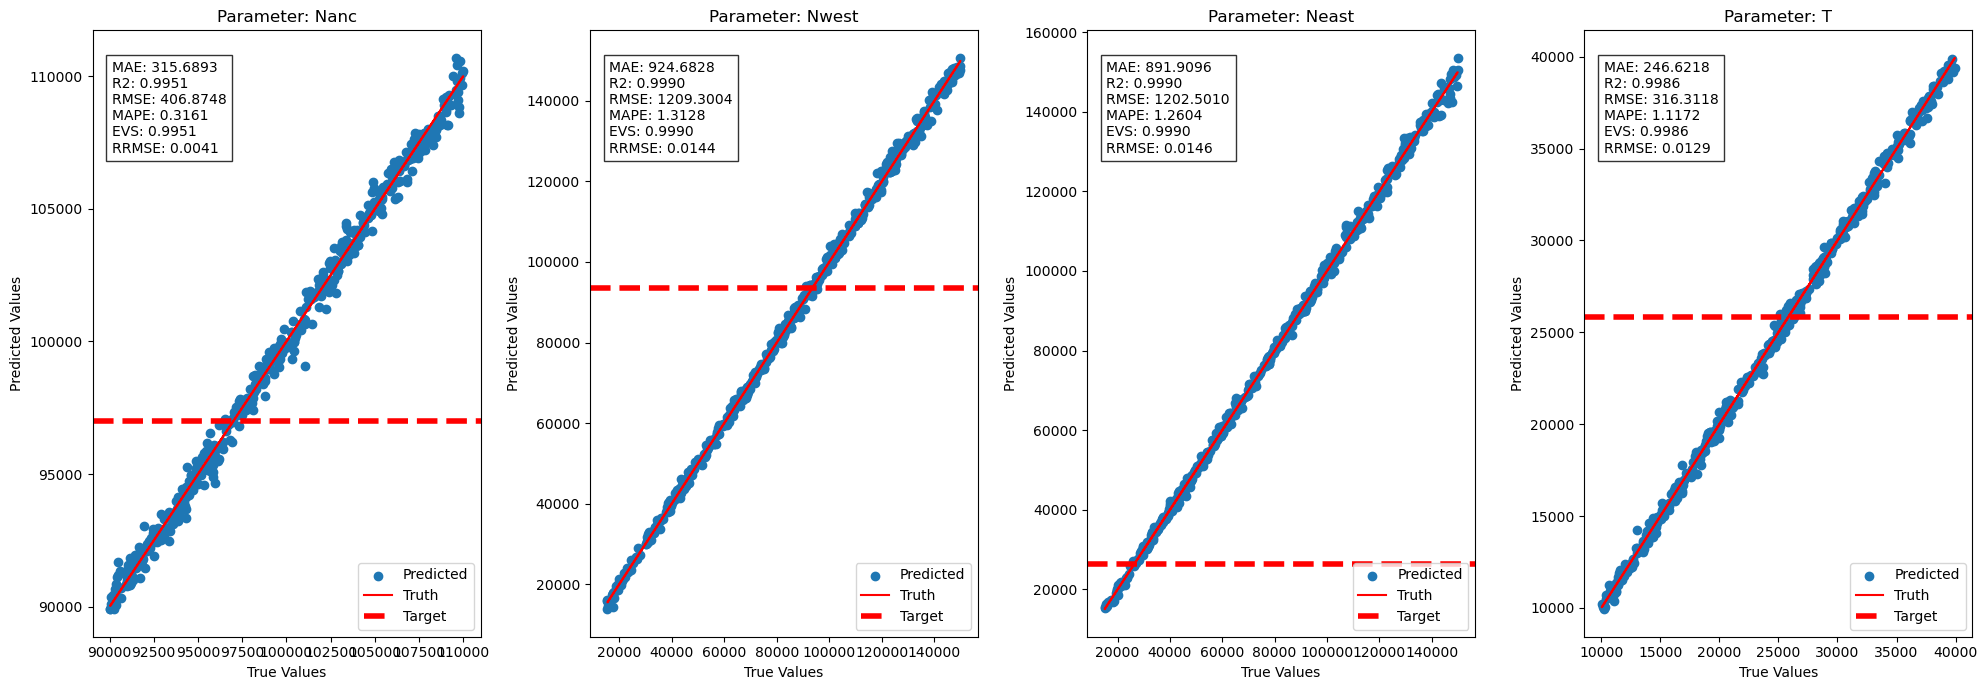

In [3]:
# Load the target stats file with only feature columns (not parameters)
target_stats_path = '/nas/longleaf/home/adaigle/work/ghist_2024_work/split_hugepriors/split2/target/target.stats'
target_df = pd.read_csv(target_stats_path, sep='\t')
#target_df.columns = [
#    col.replace("east", "temp").replace("west", "east").replace("temp", "west") 
#    if "east_west" not in col else col 
#    for col in target_df.columns
#]

print(target_df.columns)
target_features = target_df[feature_columns].values  # Extract only feature columns

# Scale the target features
target_features_scaled = scaler_X.transform(target_features)
target_features_tensor = torch.tensor(target_features_scaled, dtype=torch.float32)

# Predict parameter values for the target stats
model.eval()
with torch.no_grad():
    target_predictions_scaled = model(target_features_tensor).numpy()

# Inverse transform to get predictions in the original scale
target_predictions = scaler_y.inverse_transform(target_predictions_scaled)

# Define the parameter names
parameter_names = ['Nanc', 'N_west', 'N_east', 'T_split']

# Print each parameter with its value, ensuring no scientific notation
for name, value in zip(parameter_names, target_predictions[0]):
    print(f"{name}: {value:.5f}")  # Adjust the number of decimals as needed
# Calculate metrics for each target
def compute_metrics(true, pred):
    metrics = []
    for i in range(true.shape[1]):
        mae = mean_absolute_error(true[:, i], pred[:, i])
        rmse = np.sqrt(mean_squared_error(true[:, i], pred[:, i]))
        r2 = r2_score(true[:, i], pred[:, i])
        mape = np.mean(np.abs((true[:, i] - pred[:, i]) / true[:, i])) * 100
        evs = explained_variance_score(true[:, i], pred[:, i])
        rrmse = rmse / np.mean(np.abs(true[:, i]))

        metrics.append({
            "mae": mae,
            "rmse": rmse,
            "r2": r2,
            "mape": mape,
            "evs": evs,
            "rrmse": rrmse
        })
    return metrics

metrics = compute_metrics(true_values, predictions)

# Plot the results
def plot_results(metrics, all_true_values, all_predicted_means, parameter_names, target_values):
    num_parameters = len(parameter_names)
    fig, axes = plt.subplots(1, num_parameters, figsize=(5 * num_parameters, 7))
    
    if num_parameters == 1:
        axes = [axes]
    
    for i in range(num_parameters):
        true_values = all_true_values[:, i]
        predicted_values = all_predicted_means[:, i]
        
        axes[i].scatter(true_values, predicted_values, label='Predicted')
        axes[i].plot(true_values, true_values, 'r-', label='Truth')
        axes[i].axhline(y=target_values[i], color='r', linestyle='--', linewidth=4, label='Target')  # Add dotted line for target value
        
        axes[i].set_title(f'Parameter: {parameter_names[i]}')
        axes[i].set_xlabel('True Values')
        axes[i].set_ylabel('Predicted Values')
        axes[i].legend(loc='lower right')
        
        # Display metrics
        metrics_text = (
            f'MAE: {metrics[i]["mae"]:.4f}\n'
            f'R2: {metrics[i]["r2"]:.4f}\n'
            f'RMSE: {metrics[i]["rmse"]:.4f}\n'
            f'MAPE: {metrics[i]["mape"]:.4f}\n'
            f'EVS: {metrics[i]["evs"]:.4f}\n'
            f'RRMSE: {metrics[i]["rrmse"]:.4f}'
        )
        axes[i].text(0.05, 0.95, metrics_text, transform=axes[i].transAxes, verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    # Save the plot
    #plt.savefig(os.path.join(plot_dir, 'parameter_predictions_mlp_1mil_with_target.png'))
    plt.show()

parameter_names = parameter_columns
plot_results(metrics, true_values, predictions, parameter_names, target_predictions[0])


Training with sample size: 1000


/work/users/a/d/adaigle/.conda/envs/myenv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 592 with validation loss 0.0067
Metrics for sample size 1000: [{'mae': np.float64(399.54487215438763), 'rmse': np.float64(504.85202768193056), 'r2': 0.9923939172395762, 'mape': np.float64(0.40020058008868936), 'evs': 0.9923940713064229, 'rrmse': np.float64(0.005053786344296457)}, {'mae': np.float64(2639.5368837590254), 'rmse': np.float64(3578.135399864846), 'r2': 0.9913026214408158, 'mape': np.float64(3.927150228562696), 'evs': 0.9913206190546425, 'rrmse': np.float64(0.04258633199423799)}, {'mae': np.float64(2349.003338143236), 'rmse': np.float64(3383.439531707046), 'r2': 0.9920160368052509, 'mape': np.float64(3.3947893191659215), 'evs': 0.9920168744448141, 'rrmse': np.float64(0.04094394827050034)}, {'mae': np.float64(559.3771683924342), 'rmse': np.float64(719.8314432738886), 'r2': 0.9926016437929024, 'mape': np.float64(2.536656101603037), 'evs': 0.9926023533832611, 'rrmse': np.float64(0.029160168832212455)}]
Nanc: 98453.28125
N_west: 109557.53125
N_east: 22805.

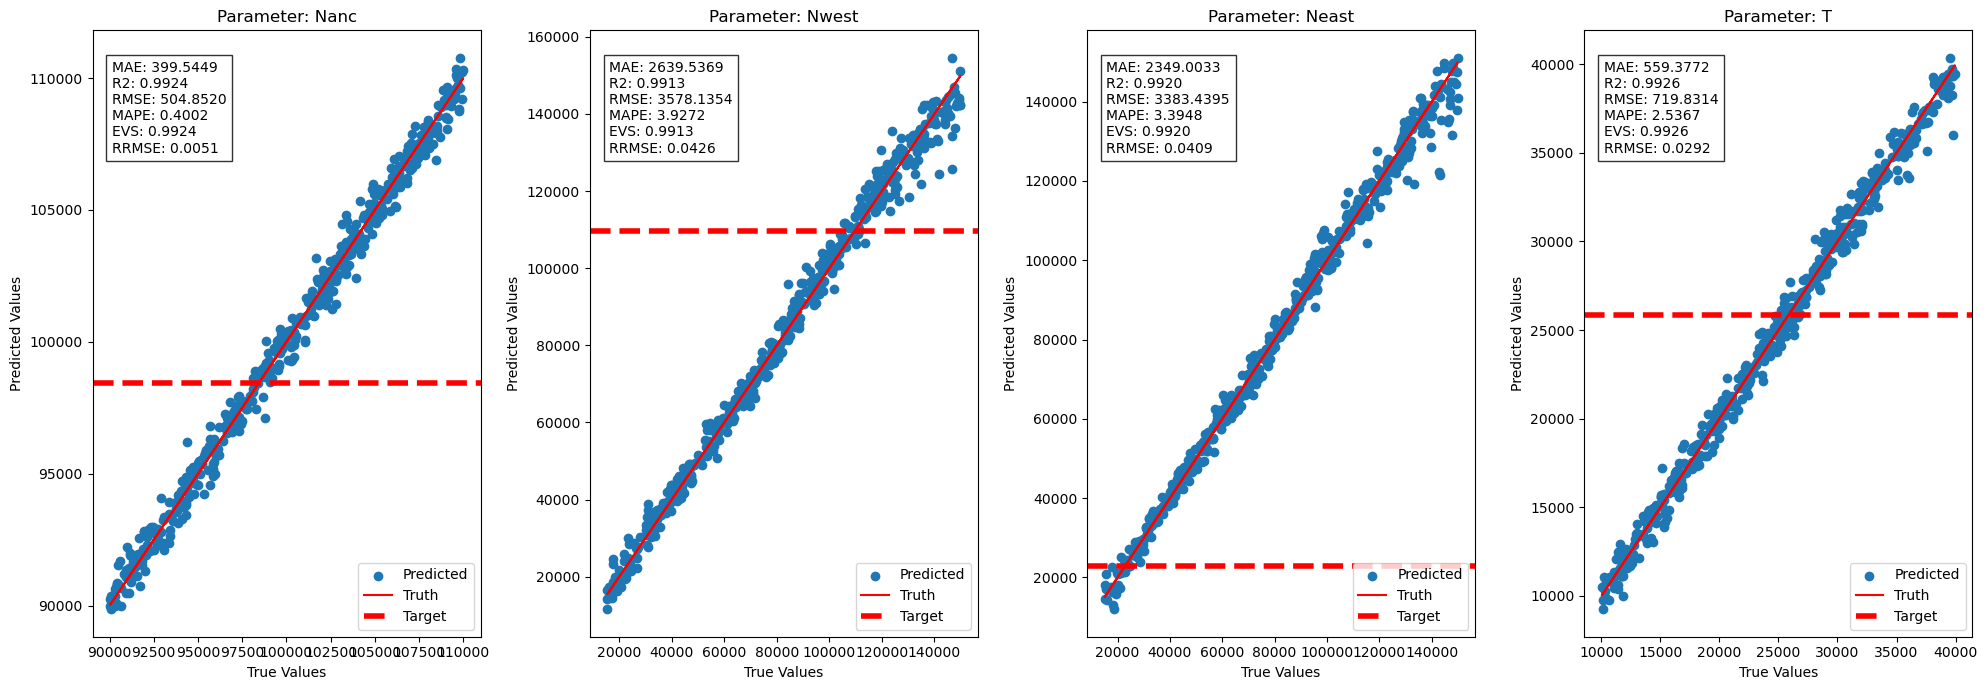


Training with sample size: 2000


/work/users/a/d/adaigle/.conda/envs/myenv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 964 with validation loss 0.0047
Metrics for sample size 2000: [{'mae': np.float64(398.25194852780925), 'rmse': np.float64(511.55526646213553), 'r2': 0.9921905948057006, 'mape': np.float64(0.3992027615707912), 'evs': 0.9922057067699465, 'rrmse': np.float64(0.005120888652997694)}, {'mae': np.float64(1798.9823586067296), 'rmse': np.float64(2516.889531079293), 'r2': 0.9956966849654371, 'mape': np.float64(2.563052014820202), 'evs': 0.995698286039822, 'rrmse': np.float64(0.029955572158452518)}, {'mae': np.float64(1796.2574961158423), 'rmse': np.float64(2498.821365346034), 'r2': 0.995645160946997, 'mape': np.float64(2.6158629587006503), 'evs': 0.9956453397906745, 'rrmse': np.float64(0.030238936372635507)}, {'mae': np.float64(447.3461316634849), 'rmse': np.float64(599.4431705314555), 'r2': 0.9948693824314175, 'mape': np.float64(2.0278138329214777), 'evs': 0.9948695646053934, 'rrmse': np.float64(0.024283273843267016)}]
Nanc: 97596.12500
N_west: 102241.70312
N_east: 29955

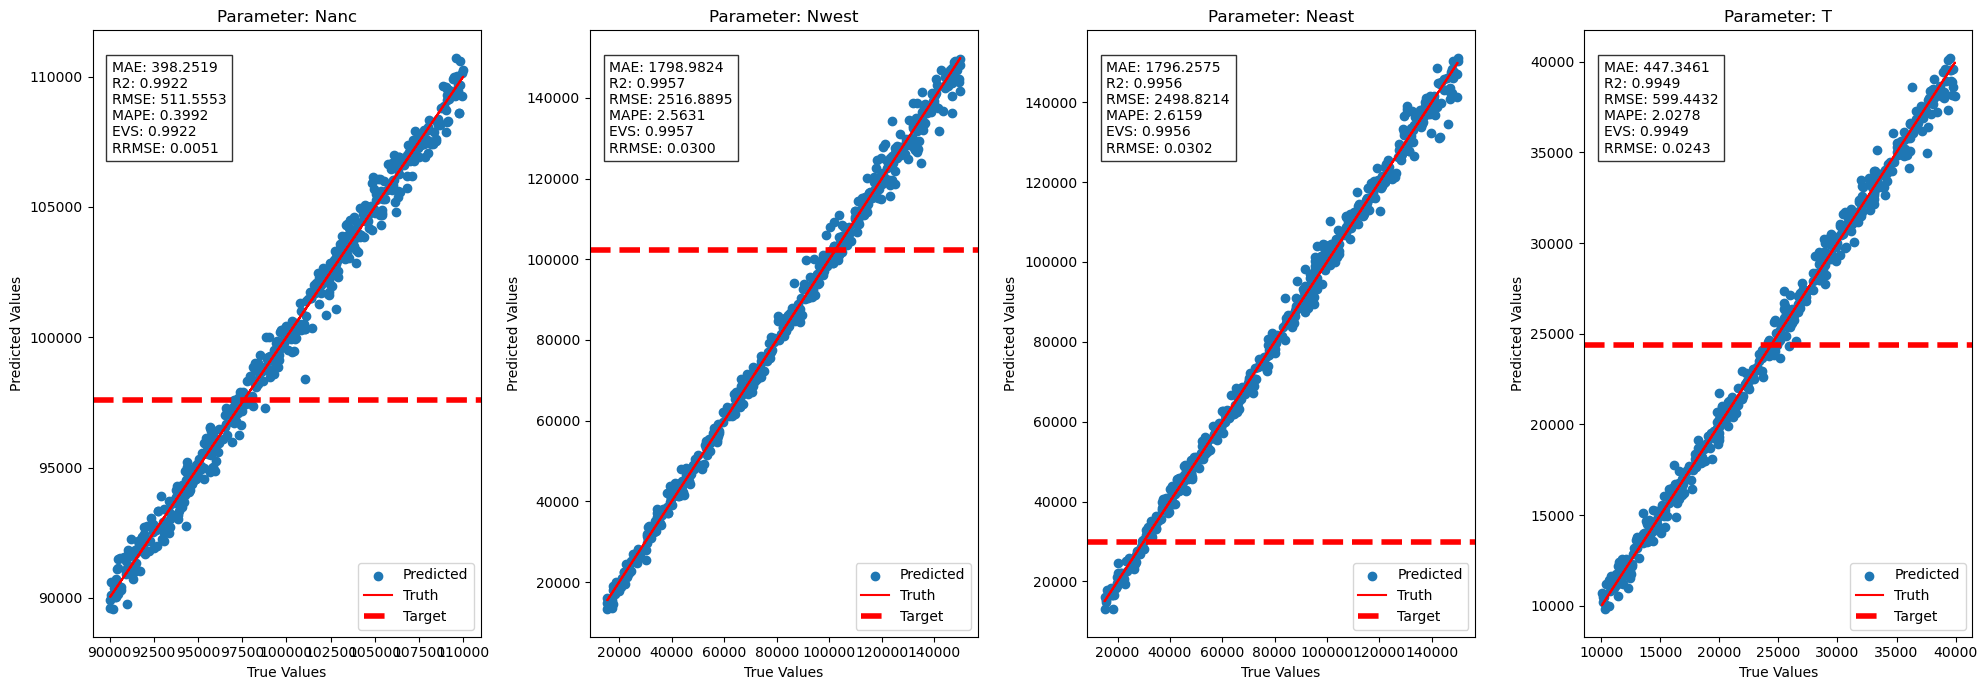


Training with sample size: 3000


/work/users/a/d/adaigle/.conda/envs/myenv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 1132 with validation loss 0.0036
Metrics for sample size 3000: [{'mae': np.float64(368.5380340273885), 'rmse': np.float64(467.24686570483493), 'r2': 0.9934848318273204, 'mape': np.float64(0.36941602892620123), 'evs': 0.9934875745641739, 'rrmse': np.float64(0.004677342468360125)}, {'mae': np.float64(1590.6826619905662), 'rmse': np.float64(2198.398182674255), 'r2': 0.996716874041779, 'mape': np.float64(2.358607448308483), 'evs': 0.9967210812811443, 'rrmse': np.float64(0.026164944698971307)}, {'mae': np.float64(1447.749644870976), 'rmse': np.float64(1991.9723734989473), 'r2': 0.9972326231117533, 'mape': np.float64(2.147371066065175), 'evs': 0.9972513826138245, 'rrmse': np.float64(0.024105414934268862)}, {'mae': np.float64(378.9034558104548), 'rmse': np.float64(486.3400315553313), 'r2': 0.9966228243603509, 'mape': np.float64(1.7081825212945014), 'evs': 0.9966254223172096, 'rrmse': np.float64(0.019701497569370525)}]
Nanc: 98549.28906
N_west: 97740.50000
N_east: 25551

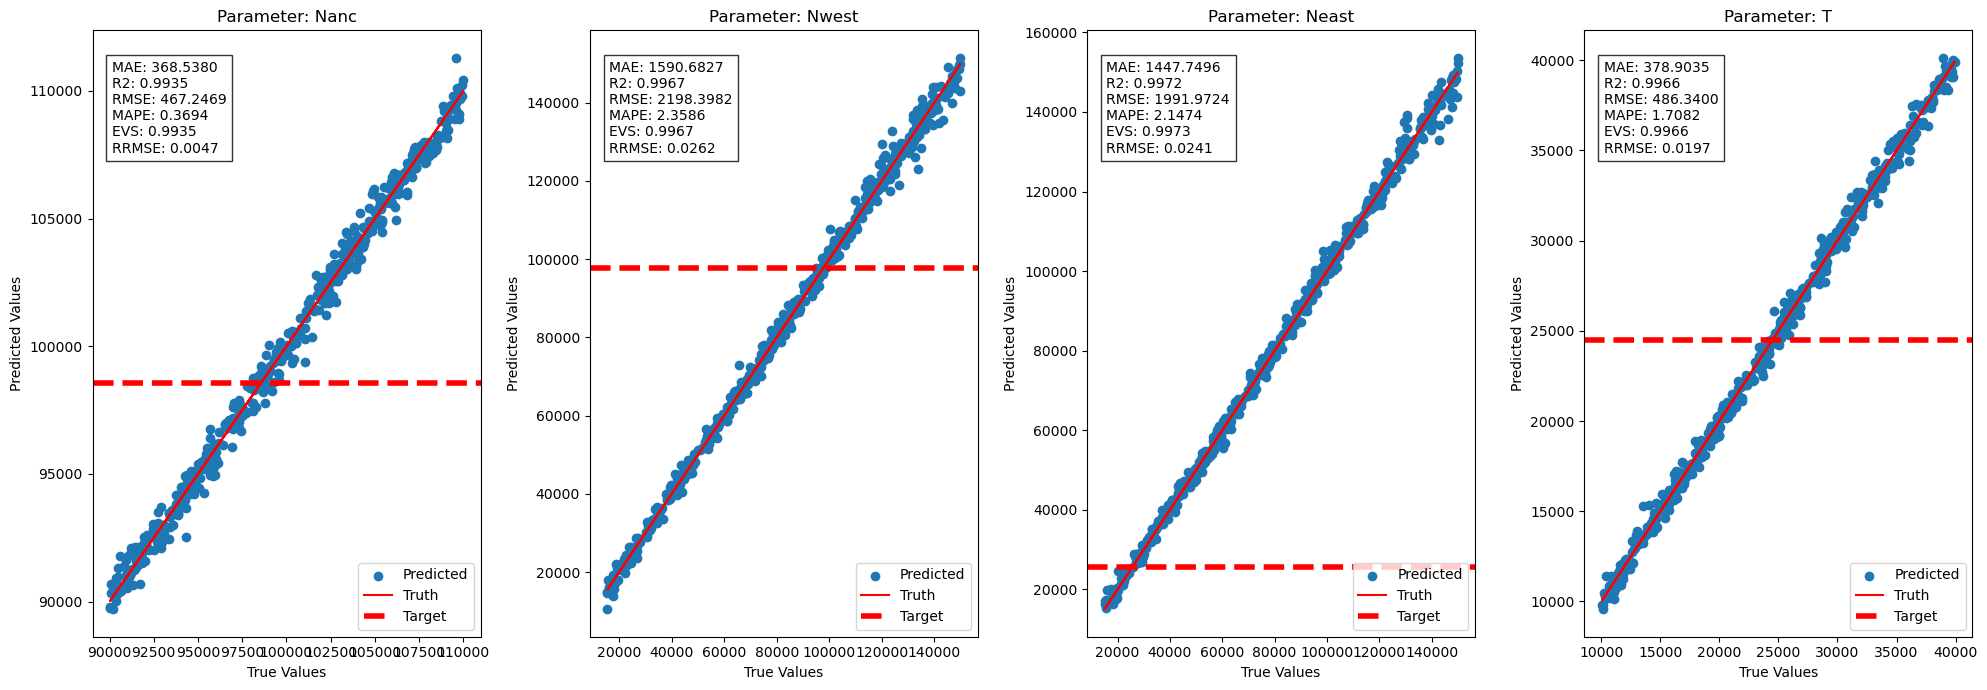


Training with sample size: 4000


/work/users/a/d/adaigle/.conda/envs/myenv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 1112 with validation loss 0.0033
Metrics for sample size 4000: [{'mae': np.float64(354.7003143144102), 'rmse': np.float64(441.6511470310119), 'r2': 0.9941790809167118, 'mape': np.float64(0.3557510393670239), 'evs': 0.9941791475816186, 'rrmse': np.float64(0.00442111829491238)}, {'mae': np.float64(1397.098111899383), 'rmse': np.float64(1841.466158672432), 'r2': 0.997696425213817, 'mape': np.float64(2.0343534386399007), 'evs': 0.9977108671791529, 'rrmse': np.float64(0.02191680314622539)}, {'mae': np.float64(1295.8079846583757), 'rmse': np.float64(1732.6026282396251), 'r2': 0.9979063714814482, 'mape': np.float64(1.8157872107364799), 'evs': 0.9979268459253448, 'rrmse': np.float64(0.02096670908972474)}, {'mae': np.float64(366.16725722999183), 'rmse': np.float64(456.39546878197916), 'r2': 0.9970258952634672, 'mape': np.float64(1.6639069126692507), 'evs': 0.9970260799565037, 'rrmse': np.float64(0.01848845177339035)}]
Nanc: 97960.92188
N_west: 91863.77344
N_east: 30544.2

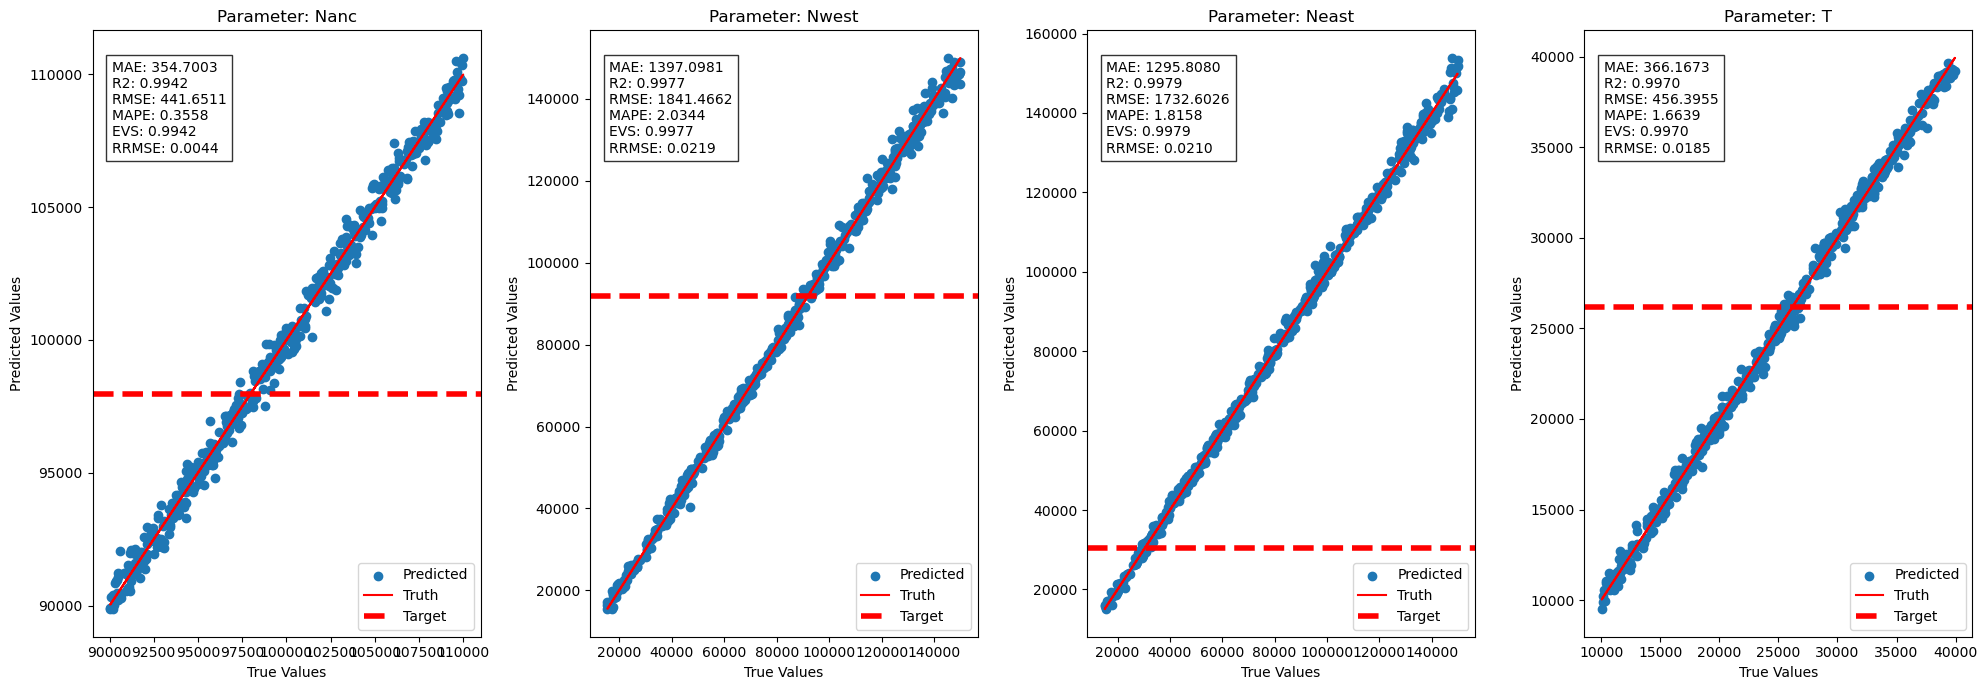


Training with sample size: 5000


/work/users/a/d/adaigle/.conda/envs/myenv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 1959 with validation loss 0.0029
Metrics for sample size 5000: [{'mae': np.float64(349.98555561626966), 'rmse': np.float64(449.3180341953272), 'r2': 0.9939752290980111, 'mape': np.float64(0.3498050882225668), 'evs': 0.9939878955668273, 'rrmse': np.float64(0.004497867139186984)}, {'mae': np.float64(1353.2062207483436), 'rmse': np.float64(1861.9471568120896), 'r2': 0.9976448990115495, 'mape': np.float64(1.9695066869626823), 'evs': 0.9976766437074055, 'rrmse': np.float64(0.02216056434832573)}, {'mae': np.float64(1165.454130872408), 'rmse': np.float64(1584.0540118211125), 'r2': 0.9982499854512538, 'mape': np.float64(1.6743334786365864), 'evs': 0.9982507499318364, 'rrmse': np.float64(0.019169080726842386)}, {'mae': np.float64(350.48716234906715), 'rmse': np.float64(459.35120743190237), 'r2': 0.9969872483342014, 'mape': np.float64(1.5639689783749446), 'evs': 0.9969894470397976, 'rrmse': np.float64(0.018608187912817178)}]
Nanc: 97499.24219
N_west: 93671.25781
N_east: 2

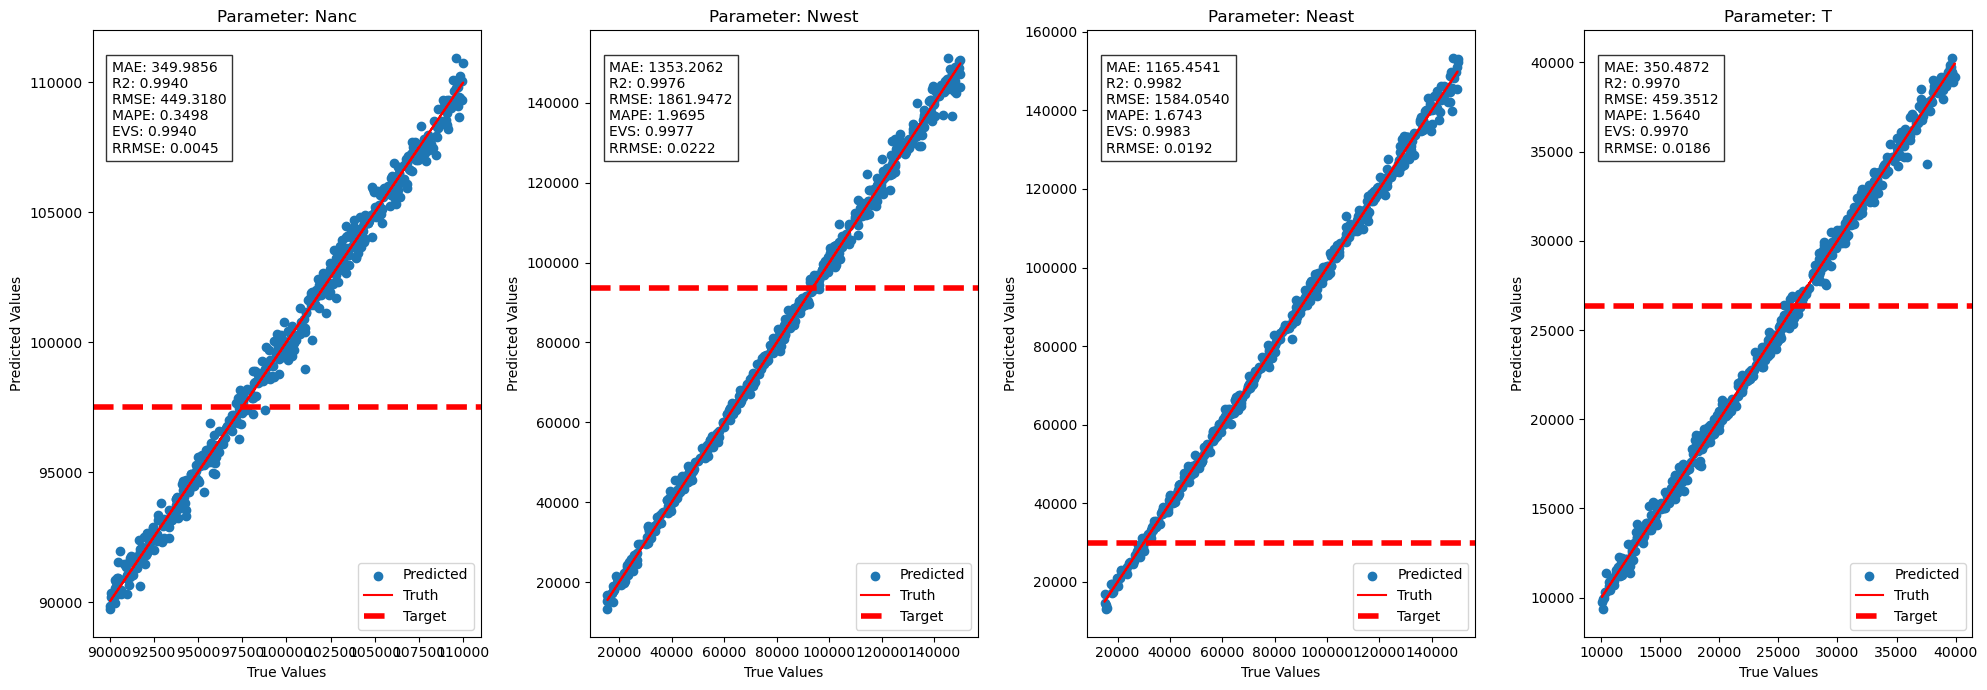


Training with sample size: 7500


/work/users/a/d/adaigle/.conda/envs/myenv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 2026 with validation loss 0.0026
Metrics for sample size 7500: [{'mae': np.float64(333.74503137428127), 'rmse': np.float64(425.384808762174), 'r2': 0.9945999623271974, 'mape': np.float64(0.33354359318091487), 'evs': 0.9946009025801245, 'rrmse': np.float64(0.00425828523946796)}, {'mae': np.float64(1058.335140744518), 'rmse': np.float64(1443.2885490202862), 'r2': 0.9985849194422325, 'mape': np.float64(1.5325536254843795), 'evs': 0.9986043530427864, 'rrmse': np.float64(0.01717776395895515)}, {'mae': np.float64(1037.9542516237448), 'rmse': np.float64(1381.4587976849166), 'r2': 0.9986690015161411, 'mape': np.float64(1.6187352768833292), 'evs': 0.9986718984584587, 'rrmse': np.float64(0.016717419365760443)}, {'mae': np.float64(289.08969209885015), 'rmse': np.float64(373.4981906173305), 'r2': 0.9980081775859657, 'mape': np.float64(1.3080840038997206), 'evs': 0.9980081999549899, 'rrmse': np.float64(0.015130306405333296)}]
Nanc: 97996.38281
N_west: 95833.45312
N_east: 271

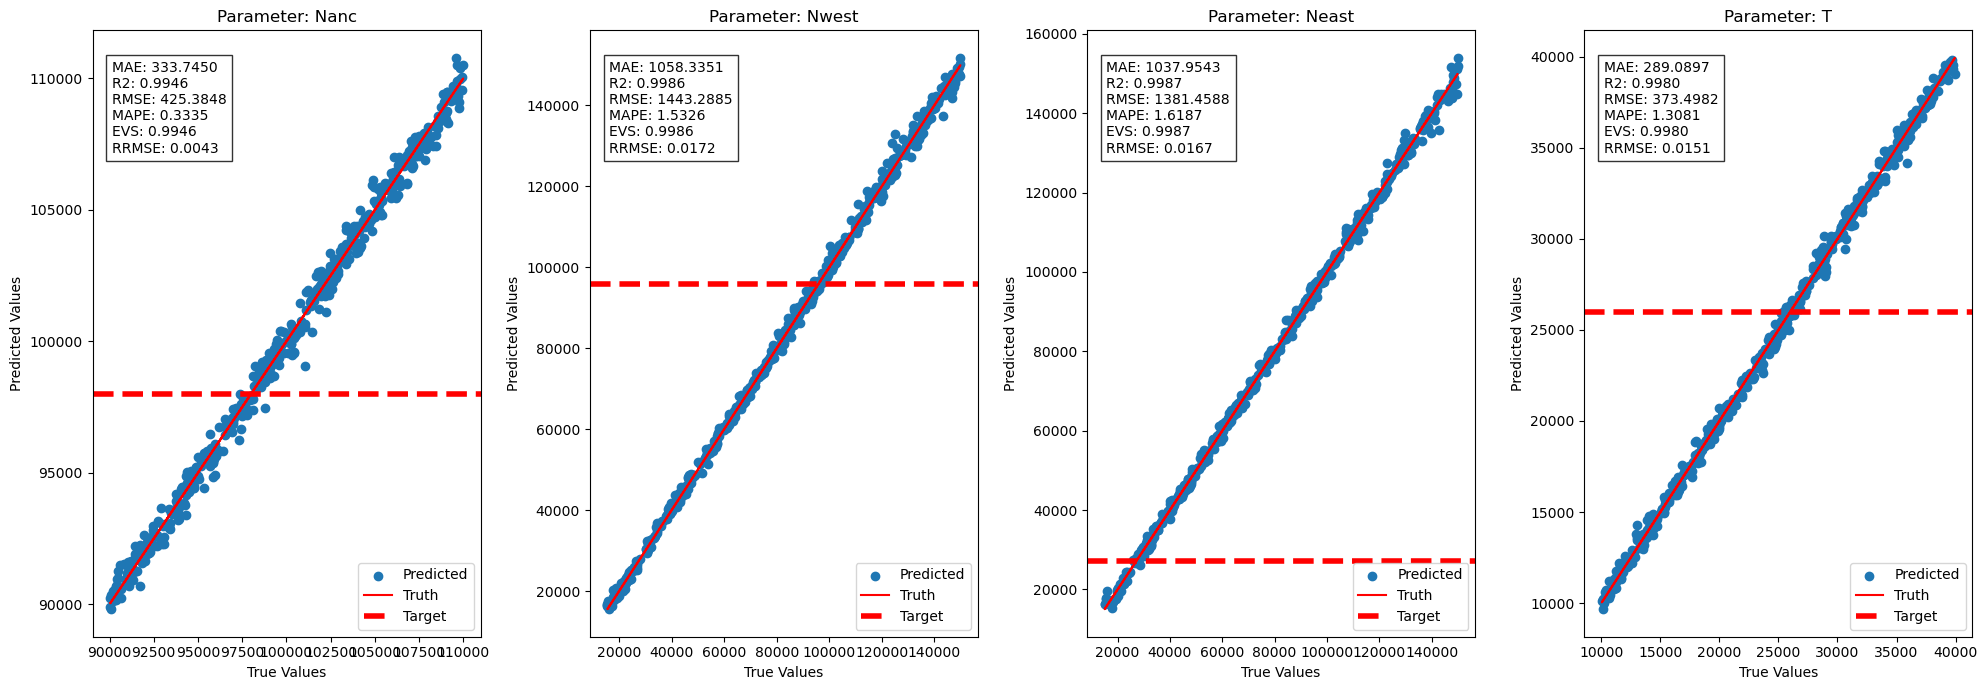


Training with sample size: 10000


/work/users/a/d/adaigle/.conda/envs/myenv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 2740 with validation loss 0.0022
Metrics for sample size 10000: [{'mae': np.float64(330.0102449281427), 'rmse': np.float64(426.3350063165328), 'r2': 0.9945758108612786, 'mape': np.float64(0.3303525103613878), 'evs': 0.9945783252844448, 'rrmse': np.float64(0.004267797126439379)}, {'mae': np.float64(985.9385594121106), 'rmse': np.float64(1325.0913848386344), 'r2': 0.9988072031241244, 'mape': np.float64(1.4023819670455735), 'evs': 0.9988130881576482, 'rrmse': np.float64(0.01577100230460093)}, {'mae': np.float64(960.3161765598609), 'rmse': np.float64(1277.810703600726), 'r2': 0.9988612333730067, 'mape': np.float64(1.3872193846809102), 'evs': 0.9988638960388412, 'rrmse': np.float64(0.015463144784302814)}, {'mae': np.float64(282.96207409432037), 'rmse': np.float64(359.00835166133817), 'r2': 0.9981597250513391, 'mape': np.float64(1.2577706909882092), 'evs': 0.9981600232187235, 'rrmse': np.float64(0.014543327114200082)}]
Nanc: 97987.45312
N_west: 95183.52344
N_east: 269

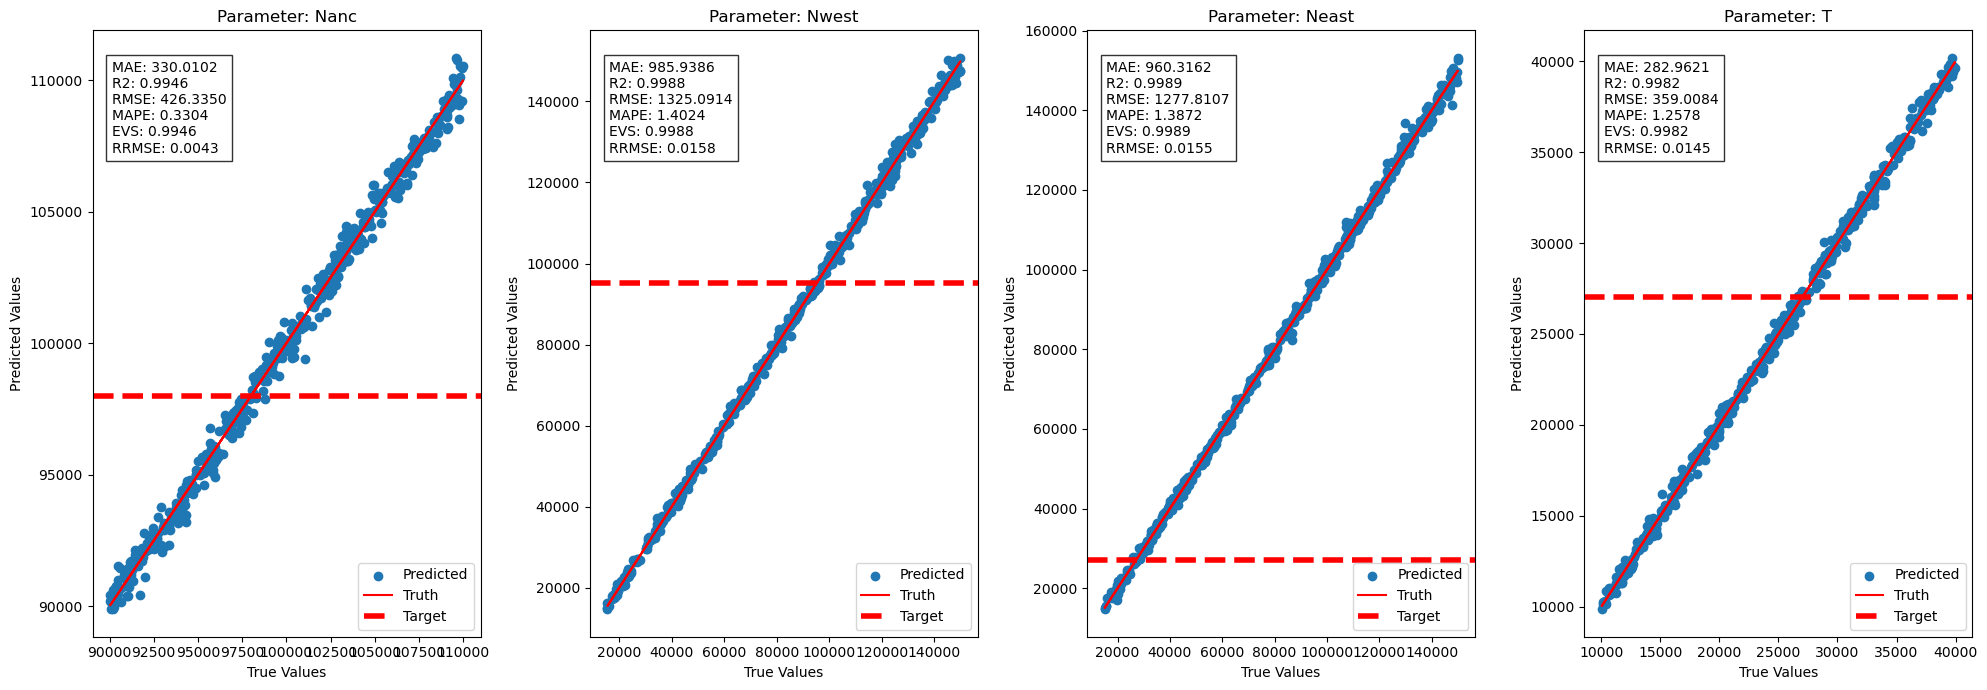


Training with sample size: 11000


/work/users/a/d/adaigle/.conda/envs/myenv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 2944 with validation loss 0.0022
Metrics for sample size 11000: [{'mae': np.float64(320.2794069899907), 'rmse': np.float64(415.04809050383125), 'r2': 0.9948592122052164, 'mape': np.float64(0.32086911728790646), 'evs': 0.994860079720711, 'rrmse': np.float64(0.004154810235477752)}, {'mae': np.float64(1043.6072335611007), 'rmse': np.float64(1350.9724113643438), 'r2': 0.9987601538646116, 'mape': np.float64(1.5910955240966147), 'evs': 0.9987606281509558, 'rrmse': np.float64(0.01607903368541932)}, {'mae': np.float64(942.2218959818186), 'rmse': np.float64(1244.2194442065727), 'r2': 0.9989203185101705, 'mape': np.float64(1.4045290703148134), 'evs': 0.9989203404445928, 'rrmse': np.float64(0.015056647557416876)}, {'mae': np.float64(268.65502761271864), 'rmse': np.float64(335.37033223139895), 'r2': 0.9983940837492083, 'mape': np.float64(1.214581032861841), 'evs': 0.9983942310031647, 'rrmse': np.float64(0.013585757611121458)}]
Nanc: 97211.07812
N_west: 91118.32812
N_east: 2

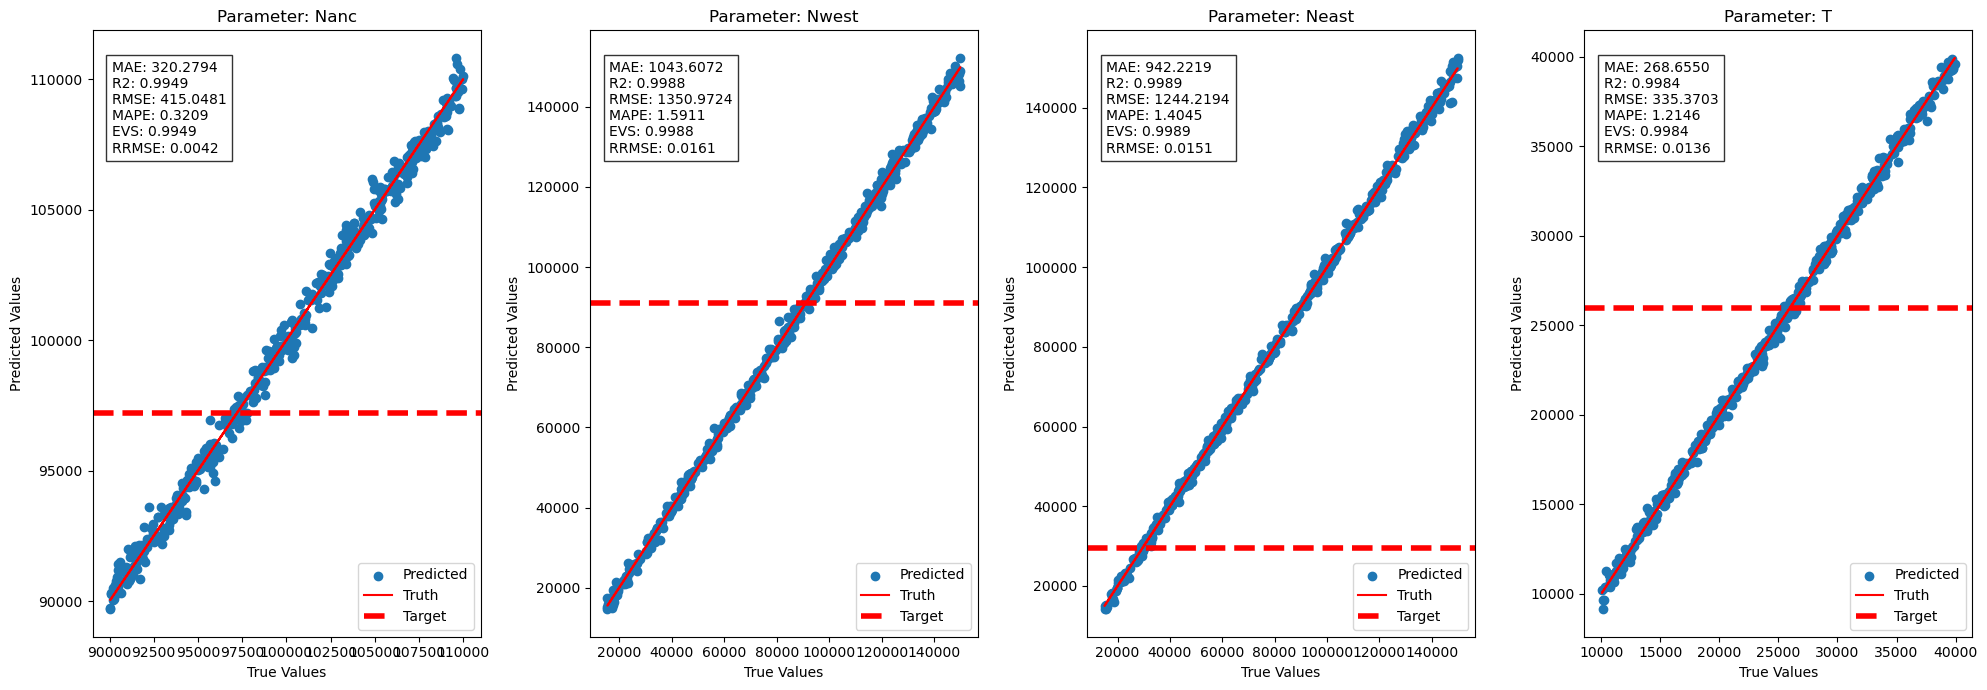


Training with sample size: 13000


/work/users/a/d/adaigle/.conda/envs/myenv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 3028 with validation loss 0.0021
Metrics for sample size 13000: [{'mae': np.float64(322.631145697722), 'rmse': np.float64(416.97750828907044), 'r2': 0.9948113055552236, 'mape': np.float64(0.3226410254182935), 'evs': 0.9948153558536494, 'rrmse': np.float64(0.0041741245389188145)}, {'mae': np.float64(958.1534031221423), 'rmse': np.float64(1267.2248538621866), 'r2': 0.9989091068962249, 'mape': np.float64(1.415493678258857), 'evs': 0.998912525682333, 'rrmse': np.float64(0.01508228513095486)}, {'mae': np.float64(841.361294268216), 'rmse': np.float64(1120.4001919207194), 'r2': 0.999124516356147, 'mape': np.float64(1.2404983731205916), 'evs': 0.9991245186918613, 'rrmse': np.float64(0.013558276147798034)}, {'mae': np.float64(264.8940563399389), 'rmse': np.float64(342.02244570970254), 'r2': 0.998329744820988, 'mape': np.float64(1.1892198558608231), 'evs': 0.9983302006713696, 'rrmse': np.float64(0.01385523285276433)}]
Nanc: 97072.53125
N_west: 95556.19531
N_east: 27216.37

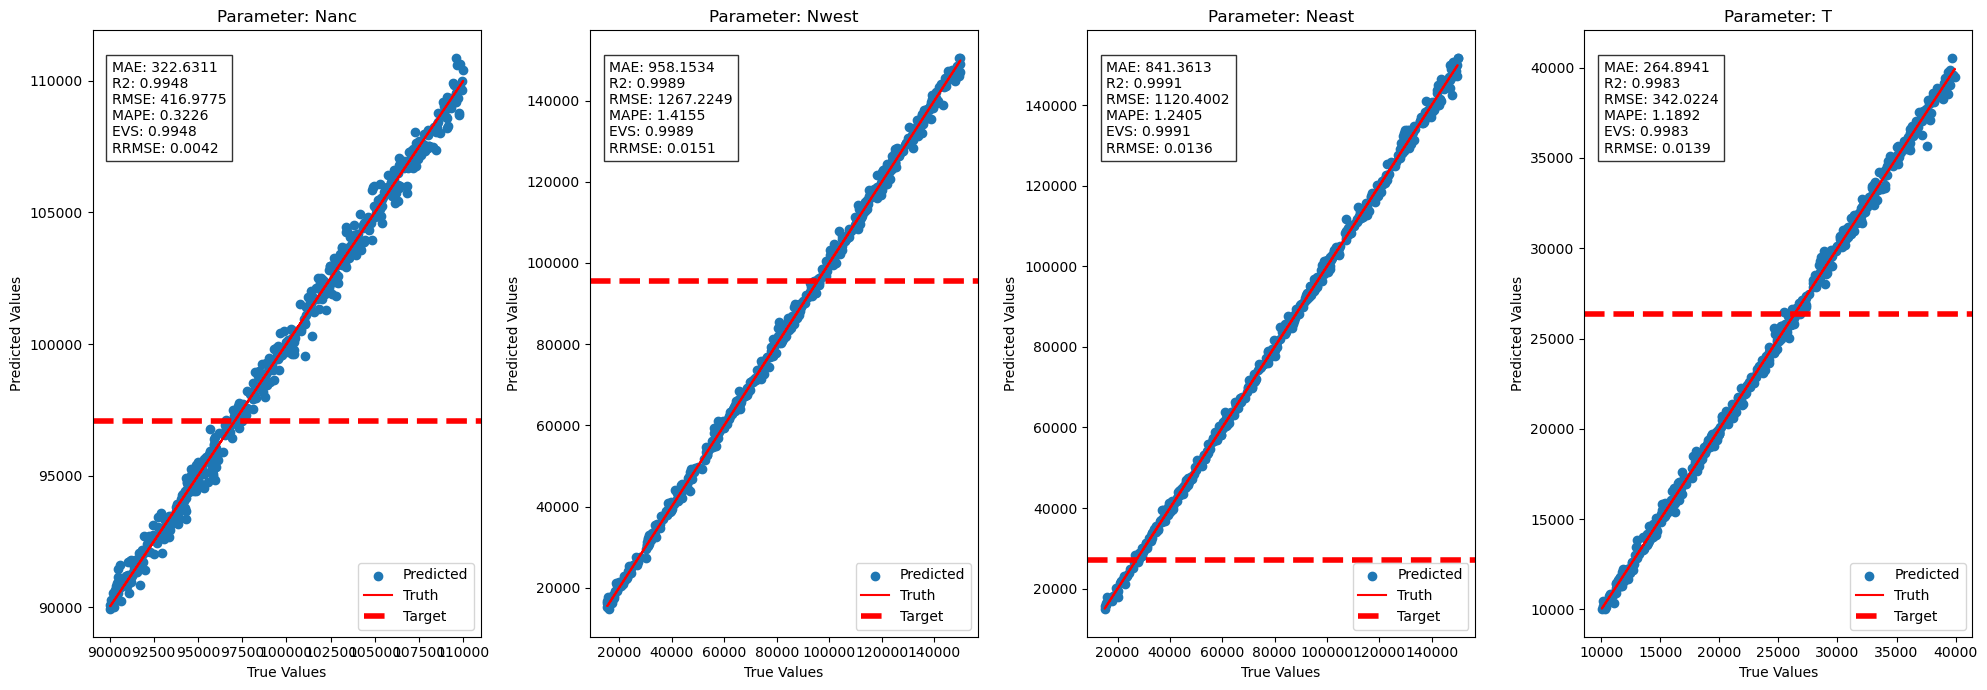

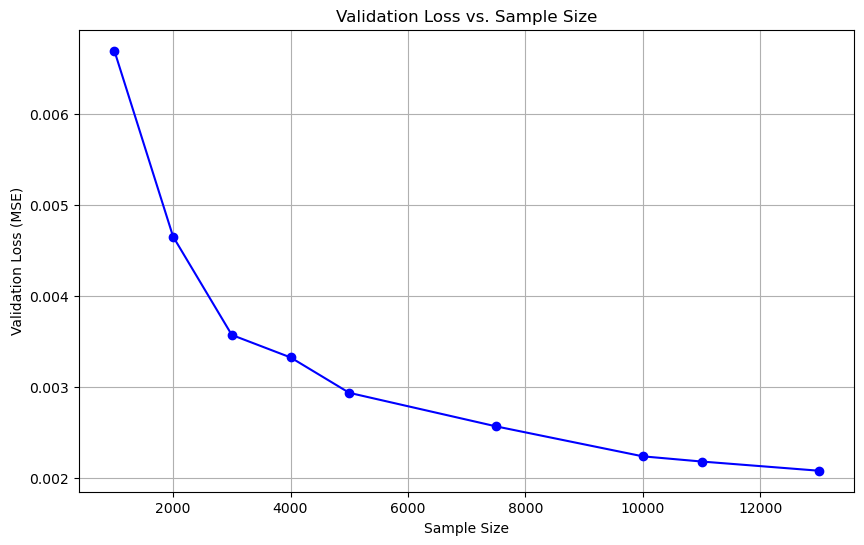

In [7]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, explained_variance_score

# List to store validation losses for each sample size
validation_losses = []

# Define a function to train and validate the model with different sample sizes
def train_with_sample_size(sample_size, X, y, feature_columns, parameter_columns):
    # Select the first `sample_size` samples for training
    X_sample, y_sample = X[:sample_size], y[:sample_size]

    # Split the sample data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

    # Scale both features and targets
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled = scaler_X.transform(X_val)
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_val_scaled = scaler_y.transform(y_val)

    # Convert scaled data to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)

    # Define the model
    input_size = X_train.shape[1]
    output_size = y_train.shape[1]
    model = MLP(input_size, output_size)

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=10, verbose=True)
    early_stopping_patience = 20
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    # Training loop with early stopping and learning rate scheduler
    num_epochs = 10000
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)

        # Learning rate scheduler step
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch + 1} with validation loss {val_loss:.4f}")
            break

    # Append final validation loss to list for plotting
    validation_losses.append(best_val_loss.item())

    # Return the trained model and scalers for later use
    return model, scaler_X, scaler_y

# Initialize datasets
X = df_remaining[feature_columns].values
y = df_remaining[parameter_columns].values

# Sample sizes to experiment with
sample_sizes = [1000, 2000, 3000, 4000, 5000, 7500, 10000, 11000, 13000]#, 17500, 20000]

# Loop through each sample size
for sample_size in sample_sizes:
    print(f"\nTraining with sample size: {sample_size}")
    model, scaler_X, scaler_y = train_with_sample_size(sample_size, X, y, feature_columns, parameter_columns)

    # Predict on the first 500 samples
    X_first_100 = df_first_100[feature_columns].values
    X_first_100_scaled = scaler_X.transform(X_first_100)
    X_first_100_tensor = torch.tensor(X_first_100_scaled, dtype=torch.float32)

    # Make predictions
    model.eval()
    with torch.no_grad():
        predictions_scaled = model(X_first_100_tensor).numpy()

    # Inverse transform the scaled predictions and true values
    predictions = scaler_y.inverse_transform(predictions_scaled)
    true_values = df_first_100[parameter_columns].values

    # Calculate metrics
    metrics = compute_metrics(true_values, predictions)
    print(f"Metrics for sample size {sample_size}: {metrics}")
    model.eval()
    with torch.no_grad():
        target_predictions_scaled = model(target_features_tensor).numpy()

    # Inverse transform to get predictions in the original scale
    target_predictions = scaler_y.inverse_transform(target_predictions_scaled)
    # Define the parameter names
    parameter_names = ['Nanc', 'N_west', 'N_east', 'T_split']

    # Print each parameter with its value, ensuring no scientific notation
    for name, value in zip(parameter_names, target_predictions[0]):
        print(f"{name}: {value:.5f}")  # Adjust the number of decimals as needed
    # Plot results
    plot_results(metrics, true_values, predictions, parameter_columns, target_predictions[0])

# Plot validation loss vs. sample size
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, validation_losses, marker='o', linestyle='-', color='b')
plt.xlabel("Sample Size")
plt.ylabel("Validation Loss (MSE)")
plt.title("Validation Loss vs. Sample Size")
plt.grid()
plt.show()



Training Configuration 1: {'hidden_layers': [128, 64], 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001}
Epoch [10/10000] - Loss: 0.3315, Val Loss: 0.3280
Epoch [20/10000] - Loss: 0.1333, Val Loss: 0.1235
Epoch [30/10000] - Loss: 0.0566, Val Loss: 0.0551
Epoch [40/10000] - Loss: 0.0337, Val Loss: 0.0328
Epoch [50/10000] - Loss: 0.0234, Val Loss: 0.0242
Epoch [60/10000] - Loss: 0.0174, Val Loss: 0.0183
Epoch [70/10000] - Loss: 0.0144, Val Loss: 0.0154
Epoch [80/10000] - Loss: 0.0124, Val Loss: 0.0136
Epoch [90/10000] - Loss: 0.0110, Val Loss: 0.0122
Epoch [100/10000] - Loss: 0.0100, Val Loss: 0.0113
Epoch [110/10000] - Loss: 0.0092, Val Loss: 0.0105
Epoch [120/10000] - Loss: 0.0085, Val Loss: 0.0099
Epoch [130/10000] - Loss: 0.0079, Val Loss: 0.0093
Epoch [140/10000] - Loss: 0.0074, Val Loss: 0.0089
Epoch [150/10000] - Loss: 0.0069, Val Loss: 0.0084
Epoch [160/10000] - Loss: 0.0065, Val Loss: 0.0081
Epoch [170/10000] - 

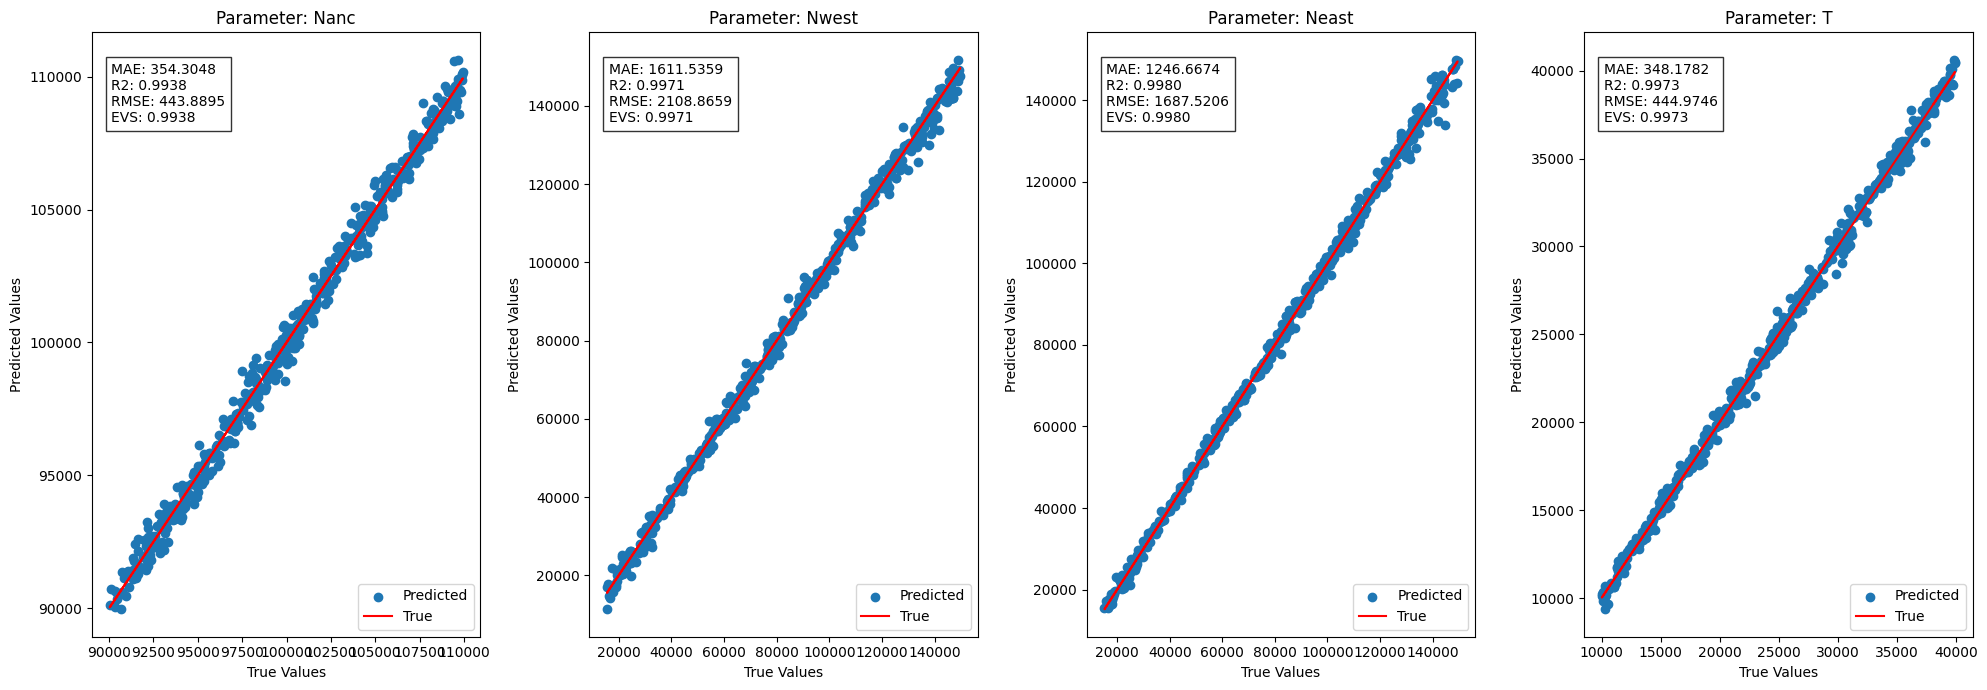


Training Configuration 2: {'hidden_layers': [256, 128, 64], 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001}
Epoch [10/10000] - Loss: 0.3643, Val Loss: 0.3514
Epoch [20/10000] - Loss: 0.1661, Val Loss: 0.1627
Epoch [30/10000] - Loss: 0.0612, Val Loss: 0.0606
Epoch [40/10000] - Loss: 0.0303, Val Loss: 0.0317
Epoch [50/10000] - Loss: 0.0199, Val Loss: 0.0202
Epoch [60/10000] - Loss: 0.0138, Val Loss: 0.0147
Epoch [70/10000] - Loss: 0.0108, Val Loss: 0.0120
Epoch [80/10000] - Loss: 0.0090, Val Loss: 0.0102
Epoch [90/10000] - Loss: 0.0078, Val Loss: 0.0092
Epoch [100/10000] - Loss: 0.0069, Val Loss: 0.0084
Epoch [110/10000] - Loss: 0.0062, Val Loss: 0.0077
Epoch [120/10000] - Loss: 0.0057, Val Loss: 0.0073
Epoch [130/10000] - Loss: 0.0053, Val Loss: 0.0068
Epoch [140/10000] - Loss: 0.0049, Val Loss: 0.0065
Epoch [150/10000] - Loss: 0.0046, Val Loss: 0.0062
Epoch [160/10000] - Loss: 0.0043, Val Loss: 0.0059
Epoch [170

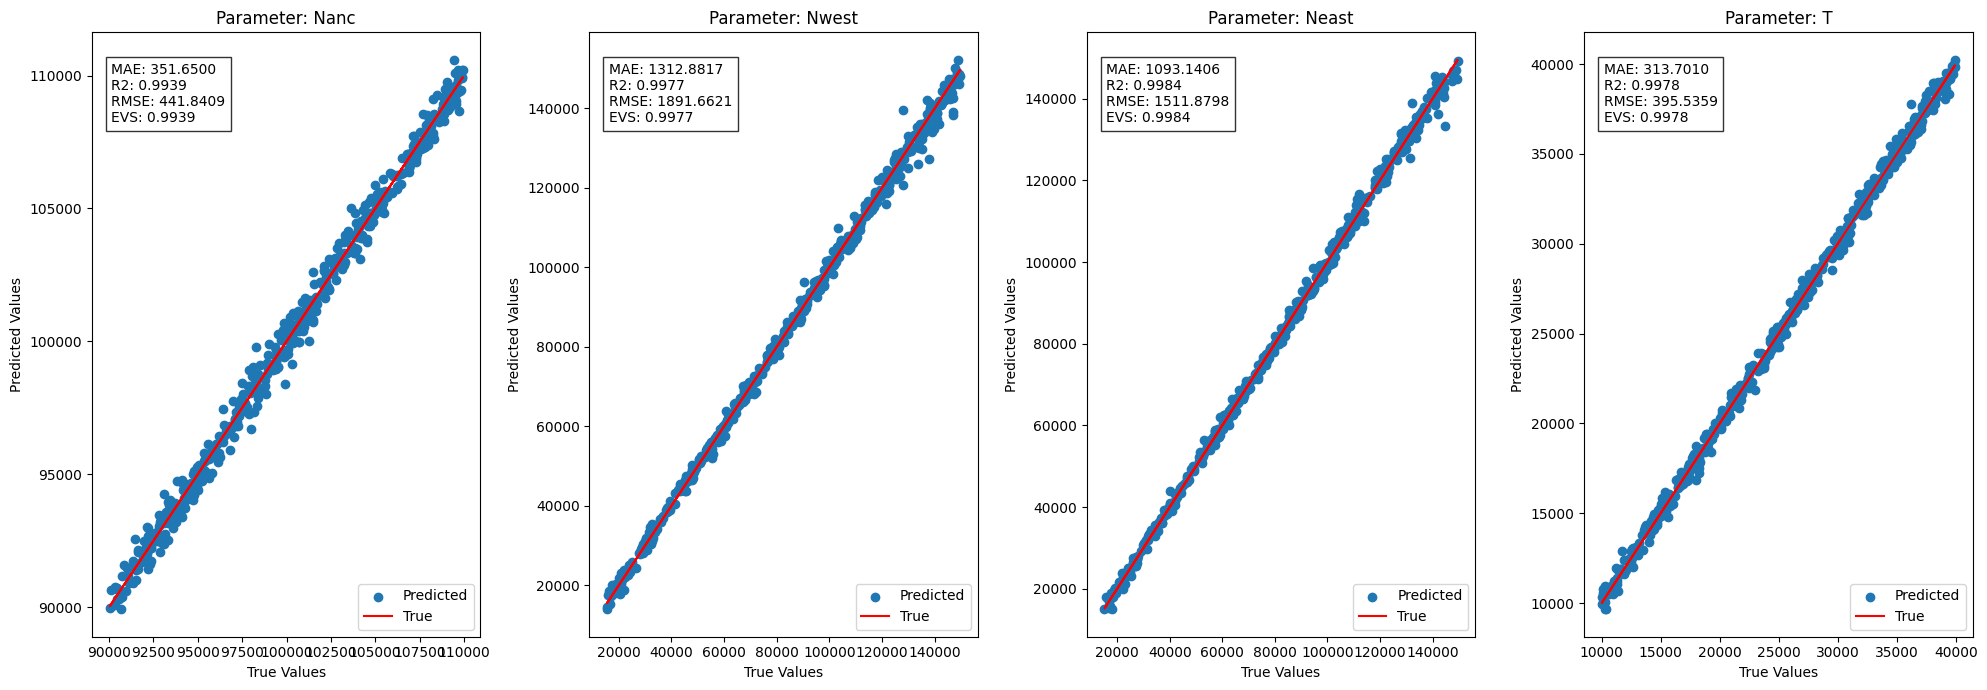


Training Configuration 3: {'hidden_layers': [128, 128, 64, 32], 'activation': <class 'torch.nn.modules.activation.Tanh'>, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'lr': 0.01}
Epoch [10/10000] - Loss: 0.9707, Val Loss: 0.9789
Epoch [20/10000] - Loss: 0.9182, Val Loss: 0.9262
Epoch [30/10000] - Loss: 0.8677, Val Loss: 0.8752
Epoch [40/10000] - Loss: 0.8184, Val Loss: 0.8254
Epoch [50/10000] - Loss: 0.7706, Val Loss: 0.7772
Epoch [60/10000] - Loss: 0.7252, Val Loss: 0.7315
Epoch [70/10000] - Loss: 0.6827, Val Loss: 0.6890
Epoch [80/10000] - Loss: 0.6438, Val Loss: 0.6501
Epoch [90/10000] - Loss: 0.6086, Val Loss: 0.6151
Epoch [100/10000] - Loss: 0.5767, Val Loss: 0.5835
Epoch [110/10000] - Loss: 0.5478, Val Loss: 0.5550
Epoch [120/10000] - Loss: 0.5214, Val Loss: 0.5290
Epoch [130/10000] - Loss: 0.4972, Val Loss: 0.5052
Epoch [140/10000] - Loss: 0.4747, Val Loss: 0.4829
Epoch [150/10000] - Loss: 0.4535, Val Loss: 0.4620
Epoch [160/10000] - Loss: 0.4333, Val Loss: 0.4420
Epoch [170/100

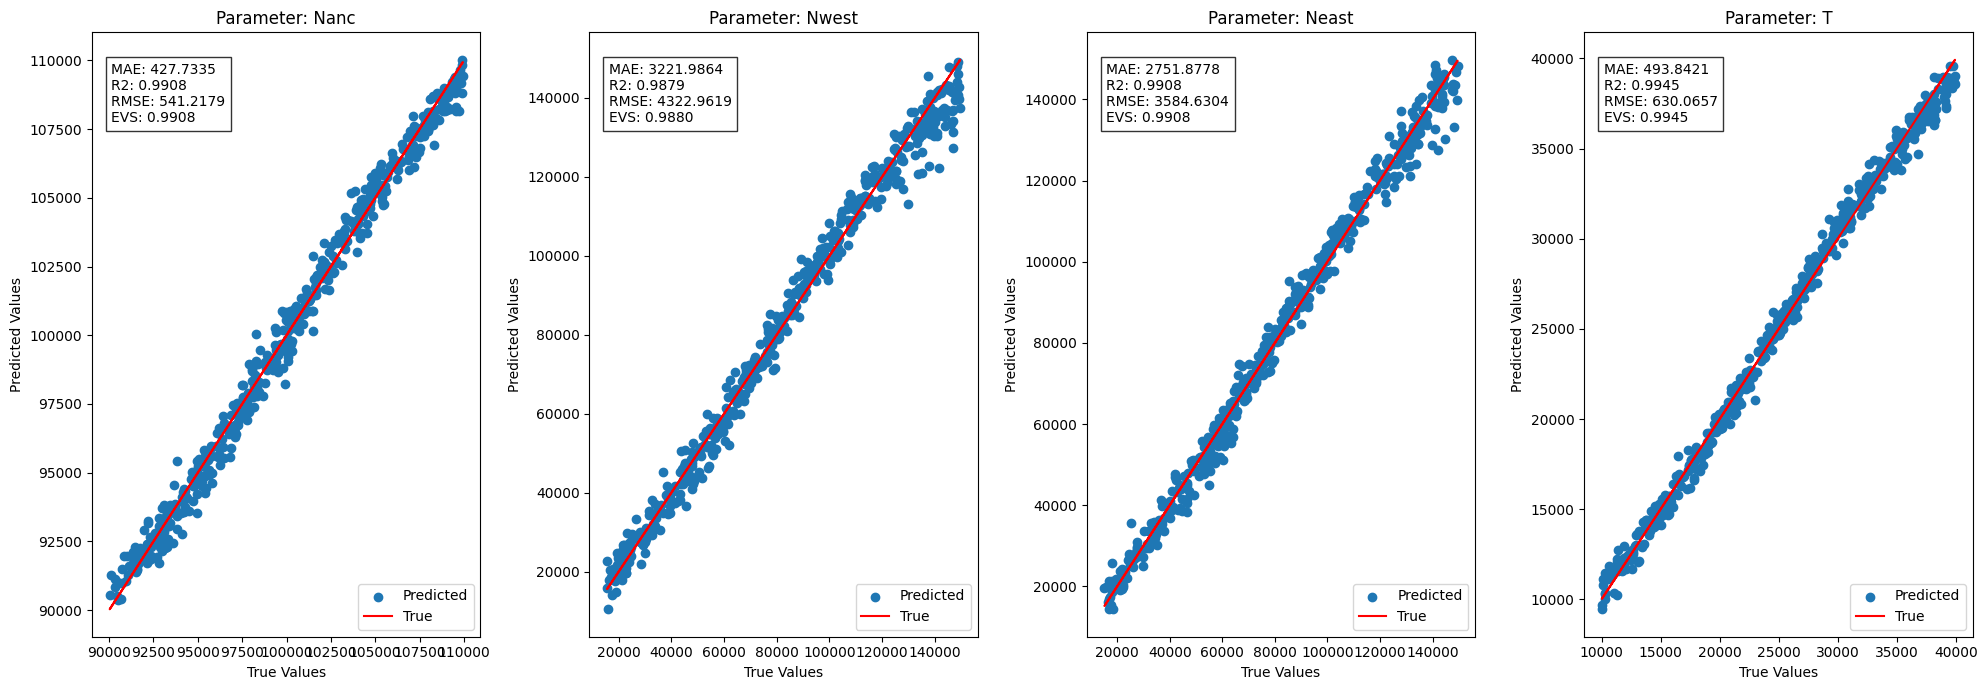


Training Configuration 4: {'hidden_layers': [64, 64, 64], 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001}
Epoch [10/10000] - Loss: 0.6506, Val Loss: 0.6253
Epoch [20/10000] - Loss: 0.3693, Val Loss: 0.3658
Epoch [30/10000] - Loss: 0.2187, Val Loss: 0.2131
Epoch [40/10000] - Loss: 0.0832, Val Loss: 0.0781
Epoch [50/10000] - Loss: 0.0500, Val Loss: 0.0482
Epoch [60/10000] - Loss: 0.0292, Val Loss: 0.0302
Epoch [70/10000] - Loss: 0.0216, Val Loss: 0.0225
Epoch [80/10000] - Loss: 0.0172, Val Loss: 0.0185
Epoch [90/10000] - Loss: 0.0144, Val Loss: 0.0160
Epoch [100/10000] - Loss: 0.0125, Val Loss: 0.0143
Epoch [110/10000] - Loss: 0.0112, Val Loss: 0.0130
Epoch [120/10000] - Loss: 0.0101, Val Loss: 0.0119
Epoch [130/10000] - Loss: 0.0092, Val Loss: 0.0110
Epoch [140/10000] - Loss: 0.0084, Val Loss: 0.0102
Epoch [150/10000] - Loss: 0.0077, Val Loss: 0.0096
Epoch [160/10000] - Loss: 0.0072, Val Loss: 0.0090
Epoch [170/10000]

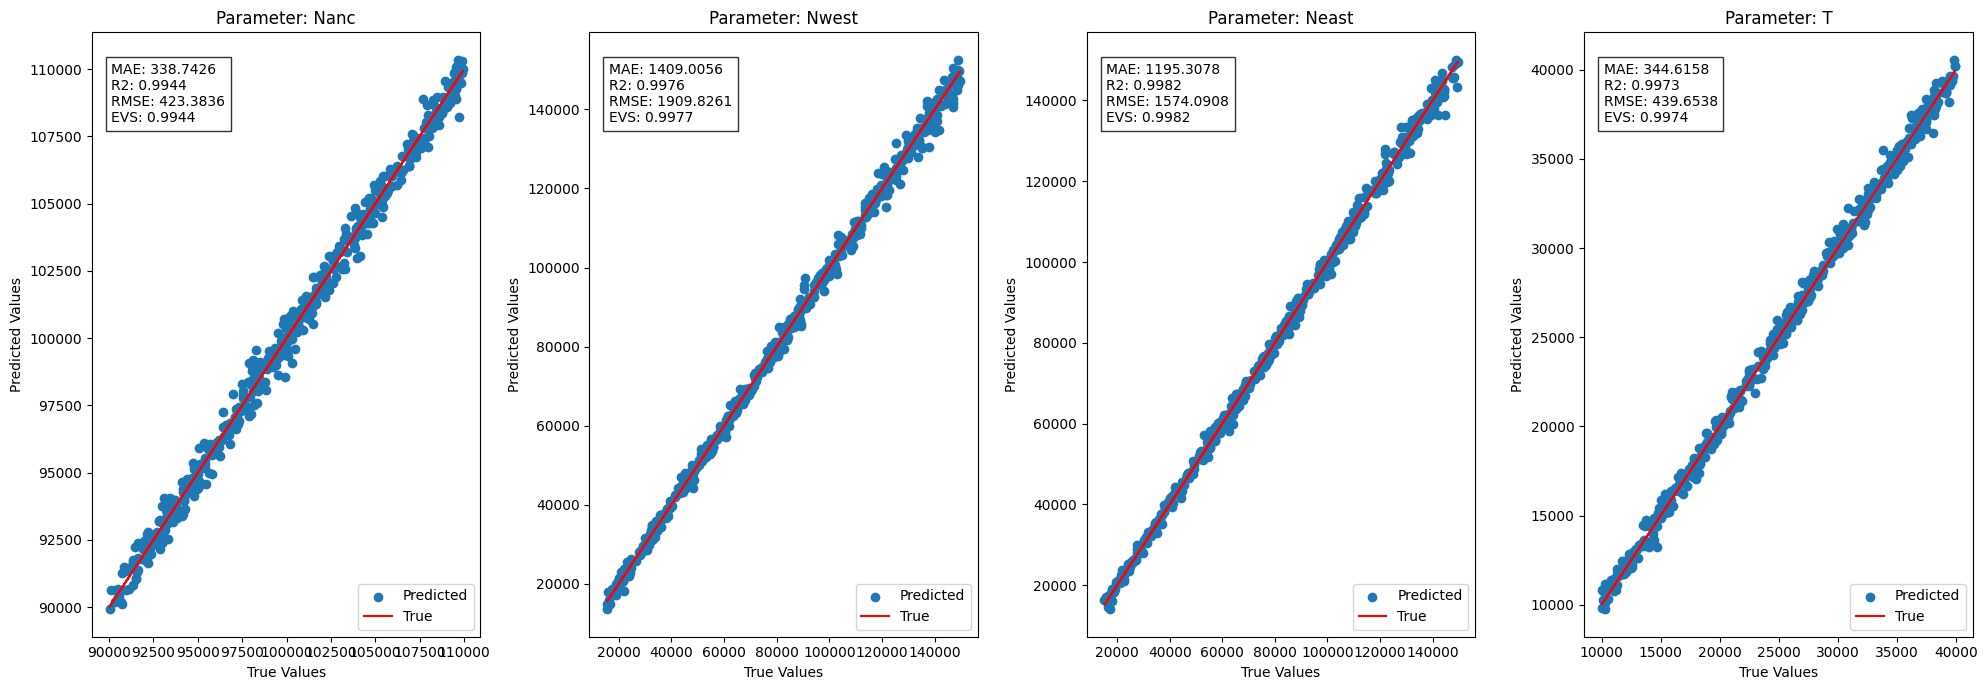


Training Configuration 5: {'hidden_layers': [256, 128], 'activation': <class 'torch.nn.modules.activation.ELU'>, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.0005}
Epoch [10/10000] - Loss: 0.2883, Val Loss: 0.2815
Epoch [20/10000] - Loss: 0.1127, Val Loss: 0.1079
Epoch [30/10000] - Loss: 0.0504, Val Loss: 0.0502
Epoch [40/10000] - Loss: 0.0356, Val Loss: 0.0365
Epoch [50/10000] - Loss: 0.0266, Val Loss: 0.0275
Epoch [60/10000] - Loss: 0.0209, Val Loss: 0.0219
Epoch [70/10000] - Loss: 0.0175, Val Loss: 0.0190
Epoch [80/10000] - Loss: 0.0151, Val Loss: 0.0166
Epoch [90/10000] - Loss: 0.0134, Val Loss: 0.0149
Epoch [100/10000] - Loss: 0.0121, Val Loss: 0.0136
Epoch [110/10000] - Loss: 0.0112, Val Loss: 0.0126
Epoch [120/10000] - Loss: 0.0104, Val Loss: 0.0118
Epoch [130/10000] - Loss: 0.0098, Val Loss: 0.0111
Epoch [140/10000] - Loss: 0.0092, Val Loss: 0.0106
Epoch [150/10000] - Loss: 0.0088, Val Loss: 0.0101
Epoch [160/10000] - Loss: 0.0084, Val Loss: 0.0096
Epoch [170/10000] -

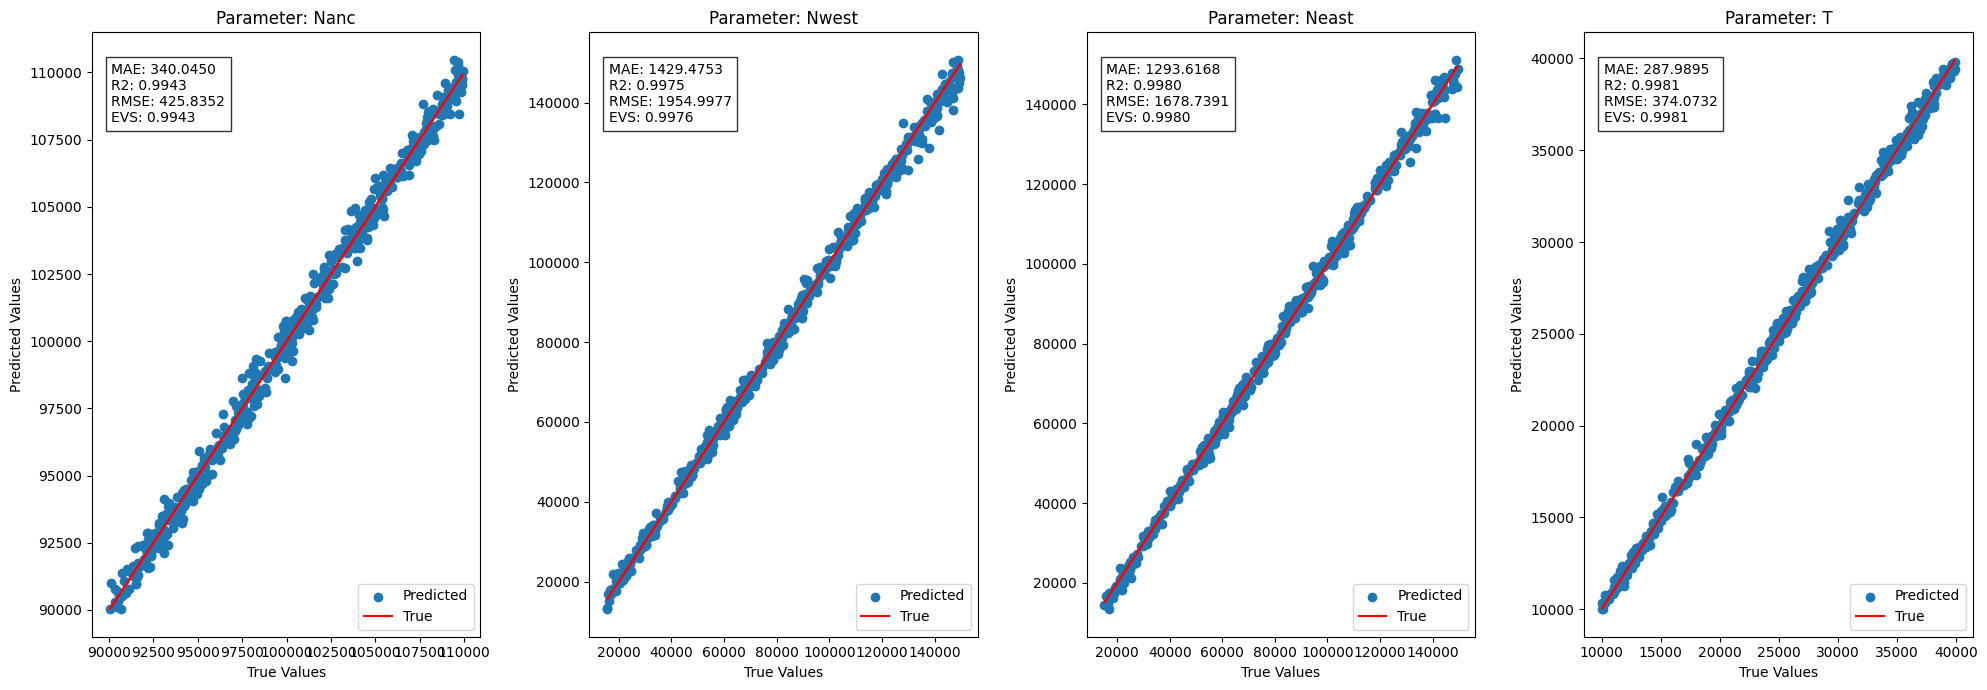


Configuration 1: {'hidden_layers': [128, 64], 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001}
Validation Loss: 0.0033
  Parameter 1 - MAE: 354.3048, RMSE: 443.8895, R2: 0.9938, EVS: 0.9938
  Parameter 2 - MAE: 1611.5359, RMSE: 2108.8659, R2: 0.9971, EVS: 0.9971
  Parameter 3 - MAE: 1246.6674, RMSE: 1687.5206, R2: 0.9980, EVS: 0.9980
  Parameter 4 - MAE: 348.1782, RMSE: 444.9746, R2: 0.9973, EVS: 0.9973

Configuration 2: {'hidden_layers': [256, 128, 64], 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001}
Validation Loss: 0.0031
  Parameter 1 - MAE: 351.6500, RMSE: 441.8409, R2: 0.9939, EVS: 0.9939
  Parameter 2 - MAE: 1312.8817, RMSE: 1891.6621, R2: 0.9977, EVS: 0.9977
  Parameter 3 - MAE: 1093.1406, RMSE: 1511.8798, R2: 0.9984, EVS: 0.9984
  Parameter 4 - MAE: 313.7010, RMSE: 395.5359, R2: 0.9978, EVS: 0.9978

Configuration 3: {'hidden_layers': [1

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, explained_variance_score
import matplotlib.pyplot as plt

# Separate the first 500 rows for later prediction
df_first_100 = df.iloc[:500, :]
df_remaining = df.iloc[500:, :]

# Define X and y for the remaining data
X = df_remaining[feature_columns].values
y = df_remaining[parameter_columns].values

# Split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features and targets
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)

# Convert scaled data to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)

# Define architectures to test
architectures = [
    {"hidden_layers": [128, 64], "activation": nn.ReLU, "optimizer": optim.Adam, "lr": 0.001},
    {"hidden_layers": [256, 128, 64], "activation": nn.LeakyReLU, "optimizer": optim.Adam, "lr": 0.001},
    {"hidden_layers": [128, 128, 64, 32], "activation": nn.Tanh, "optimizer": optim.SGD, "lr": 0.01},
    {"hidden_layers": [64, 64, 64], "activation": nn.ReLU, "optimizer": optim.Adam, "lr": 0.001},
    {"hidden_layers": [256, 128], "activation": nn.ELU, "optimizer": optim.Adam, "lr": 0.0005}
]

# Define the MLP class with flexible architecture
class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, activation):
        super(MLP, self).__init__()
        layers = []
        in_size = input_size
        for hidden_units in hidden_layers:
            layers.append(nn.Linear(in_size, hidden_units))
            layers.append(activation())
            in_size = hidden_units
        layers.append(nn.Linear(in_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Function to evaluate model and calculate metrics
def compute_metrics(true, pred):
    metrics = []
    for i in range(true.shape[1]):
        mae = mean_absolute_error(true[:, i], pred[:, i])
        rmse = np.sqrt(mean_squared_error(true[:, i], pred[:, i]))
        r2 = r2_score(true[:, i], pred[:, i])
        evs = explained_variance_score(true[:, i], pred[:, i])
        metrics.append({"mae": mae, "rmse": rmse, "r2": r2, "evs": evs})
    return metrics

# Loop through architectures and evaluate each
results = []
for idx, config in enumerate(architectures):
    print(f"\nTraining Configuration {idx + 1}: {config}")
    input_size = X_train.shape[1]
    output_size = y_train.shape[1]
    
    model = MLP(input_size, output_size, config["hidden_layers"], config["activation"])
    criterion = nn.MSELoss()
    optimizer = config["optimizer"](model.parameters(), lr=config["lr"])
    
    # Training with early stopping
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=10)
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    early_stopping_patience = 20
    num_epochs = 10000
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
        
        scheduler.step(val_loss)
        
        # Print training and validation loss every 10 epochs
        #if (epoch + 1) % 10 == 0:
        #    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch + 1} with validation loss {val_loss:.4f}")
            break
    
    # Evaluation on first 500 rows for consistency
    X_first_100_scaled = scaler_X.transform(df_first_100[feature_columns].values)
    X_first_100_tensor = torch.tensor(X_first_100_scaled, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        predictions_scaled = model(X_first_100_tensor).numpy()
    
    # Inverse transform and calculate metrics
    predictions = scaler_y.inverse_transform(predictions_scaled)
    true_values = df_first_100[parameter_columns].values
    metrics = compute_metrics(true_values, predictions)
    
    results.append({
        "config": config,
        "val_loss": best_val_loss.item(),
        "metrics": metrics,
        "predictions": predictions,
        "true_values": true_values
    })
    
    # Plotting for the current model
    parameter_names = parameter_columns
    num_parameters = len(parameter_names)
    fig, axes = plt.subplots(1, num_parameters, figsize=(5 * num_parameters, 7))
    
    if num_parameters == 1:
        axes = [axes]
    
    for i in range(num_parameters):
        true_vals = true_values[:, i]
        pred_vals = predictions[:, i]
        
        axes[i].scatter(true_vals, pred_vals, label='Predicted')
        axes[i].plot(true_vals, true_vals, 'r-', label='True')
        axes[i].set_title(f'Parameter: {parameter_names[i]}')
        axes[i].set_xlabel('True Values')
        axes[i].set_ylabel('Predicted Values')
        axes[i].legend(loc='lower right')
        
        # Display metrics
        metrics_text = (
            f'MAE: {metrics[i]["mae"]:.4f}\n'
            f'R2: {metrics[i]["r2"]:.4f}\n'
            f'RMSE: {metrics[i]["rmse"]:.4f}\n'
            f'EVS: {metrics[i]["evs"]:.4f}'
        )
        axes[i].text(0.05, 0.95, metrics_text, transform=axes[i].transAxes, 
                     verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()  # Display the plot

# Summary of results
for idx, result in enumerate(results):
    print(f"\nConfiguration {idx + 1}: {result['config']}")
    print(f"Validation Loss: {result['val_loss']:.4f}")
    for i, param_metrics in enumerate(result["metrics"]):
        print(f"  Parameter {i+1} - MAE: {param_metrics['mae']:.4f}, RMSE: {param_metrics['rmse']:.4f}, R2: {param_metrics['r2']:.4f}, EVS: {param_metrics['evs']:.4f}")


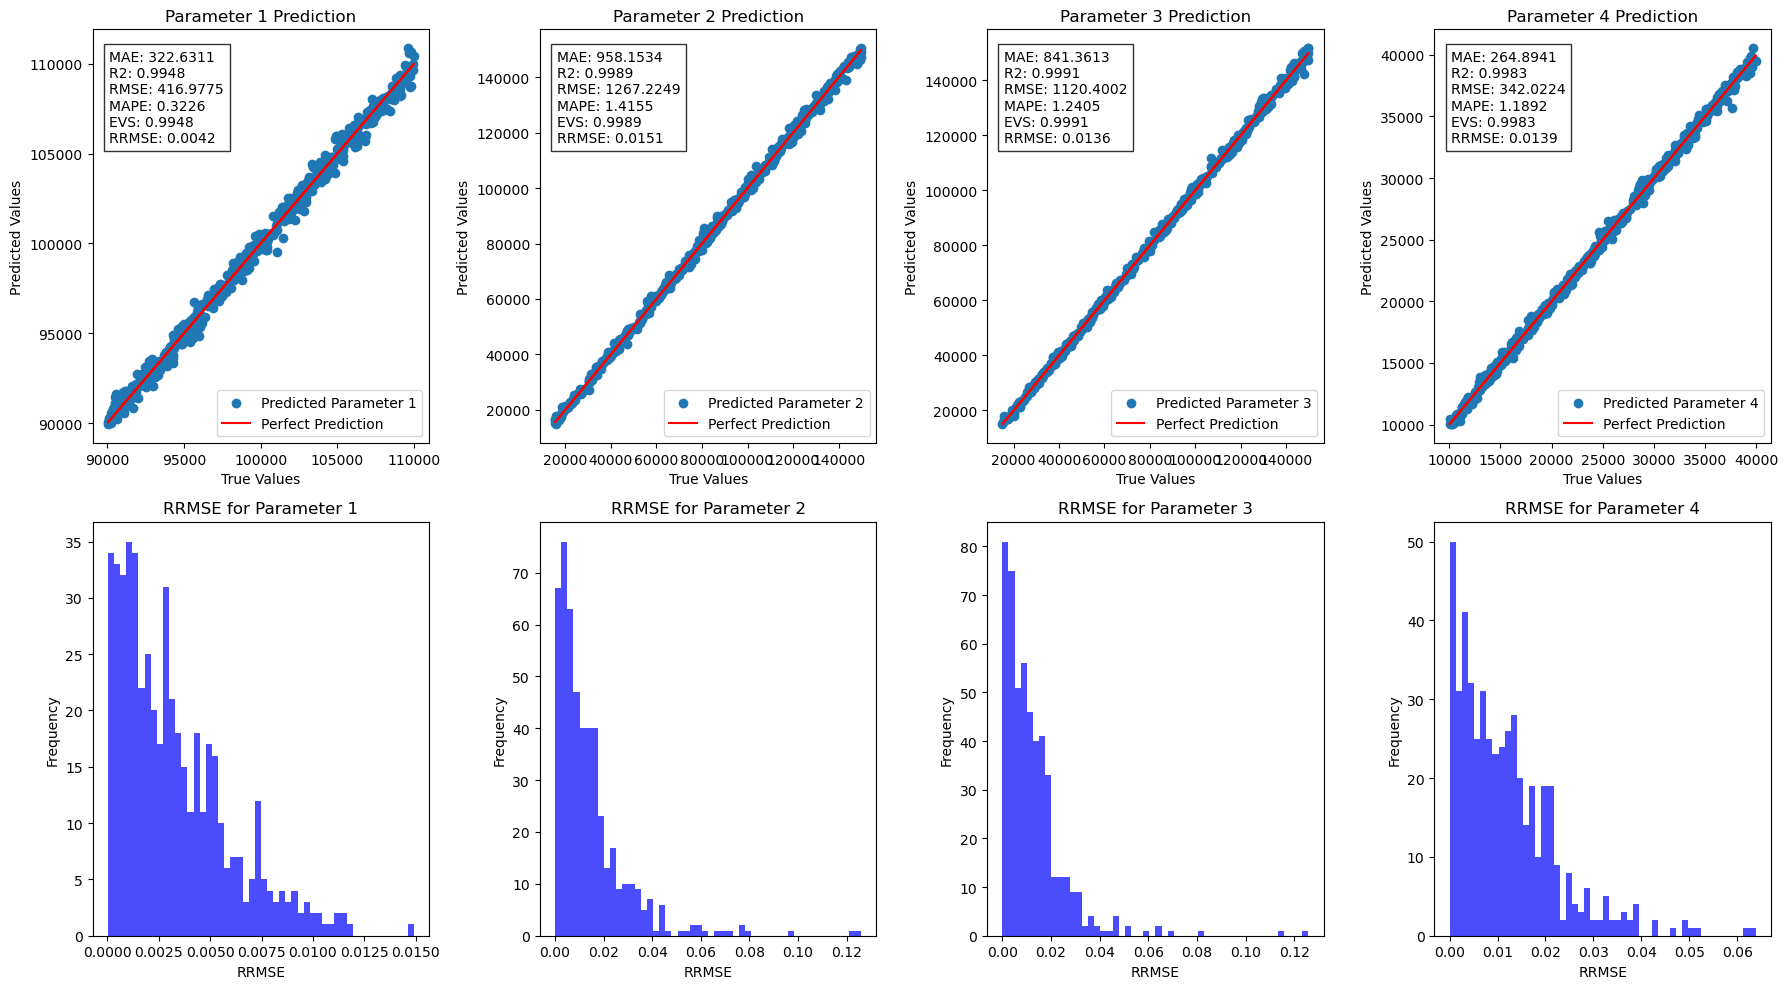

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results_with_four_plots(metrics, all_true_values, all_predicted_means):
    fig, axes = plt.subplots(2, 4, figsize=(18, 10))  # 2x4 grid for 4 parameters
    
    for i in range(4):
        # Scatter plot for each parameter (top row)
        true_values = all_true_values[:, i]
        predicted_values = all_predicted_means[:, i]
        
        axes[0, i].scatter(true_values, predicted_values, label=f'Predicted Parameter {i+1}')
        axes[0, i].plot(true_values, true_values, 'r-', label='Perfect Prediction')  # Line for perfect prediction
        axes[0, i].set_title(f'Parameter {i+1} Prediction')
        axes[0, i].set_xlabel('True Values')
        axes[0, i].set_ylabel('Predicted Values')
        axes[0, i].legend(loc='lower right')
        
        # Display metrics for each parameter
        param_metrics = compute_metrics(true_values.reshape(-1, 1), predicted_values.reshape(-1, 1))
        metrics_text = (
            f'MAE: {param_metrics[0]["mae"]:.4f}\n'
            f'R2: {param_metrics[0]["r2"]:.4f}\n'
            f'RMSE: {param_metrics[0]["rmse"]:.4f}\n'
            f'MAPE: {param_metrics[0]["mape"]:.4f}\n'
            f'EVS: {param_metrics[0]["evs"]:.4f}\n'
            f'RRMSE: {param_metrics[0]["rrmse"]:.4f}'
        )
        axes[0, i].text(0.05, 0.95, metrics_text, transform=axes[0, i].transAxes, verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

        # Calculate RRMSE for each parameter and plot histogram (bottom row)
        rrmse_per_prediction = np.abs((predicted_values - true_values) / true_values)  # RRMSE per prediction
        axes[1, i].hist(rrmse_per_prediction, bins=50, color='blue', alpha=0.7)
        axes[1, i].set_title(f'RRMSE for Parameter {i+1}')
        axes[1, i].set_xlabel('RRMSE')
        axes[1, i].set_ylabel('Frequency')
    
    plt.tight_layout()
    return plt

# Call the function
plot = plot_results_with_four_plots(metrics, true_values, predictions)
plot.show()


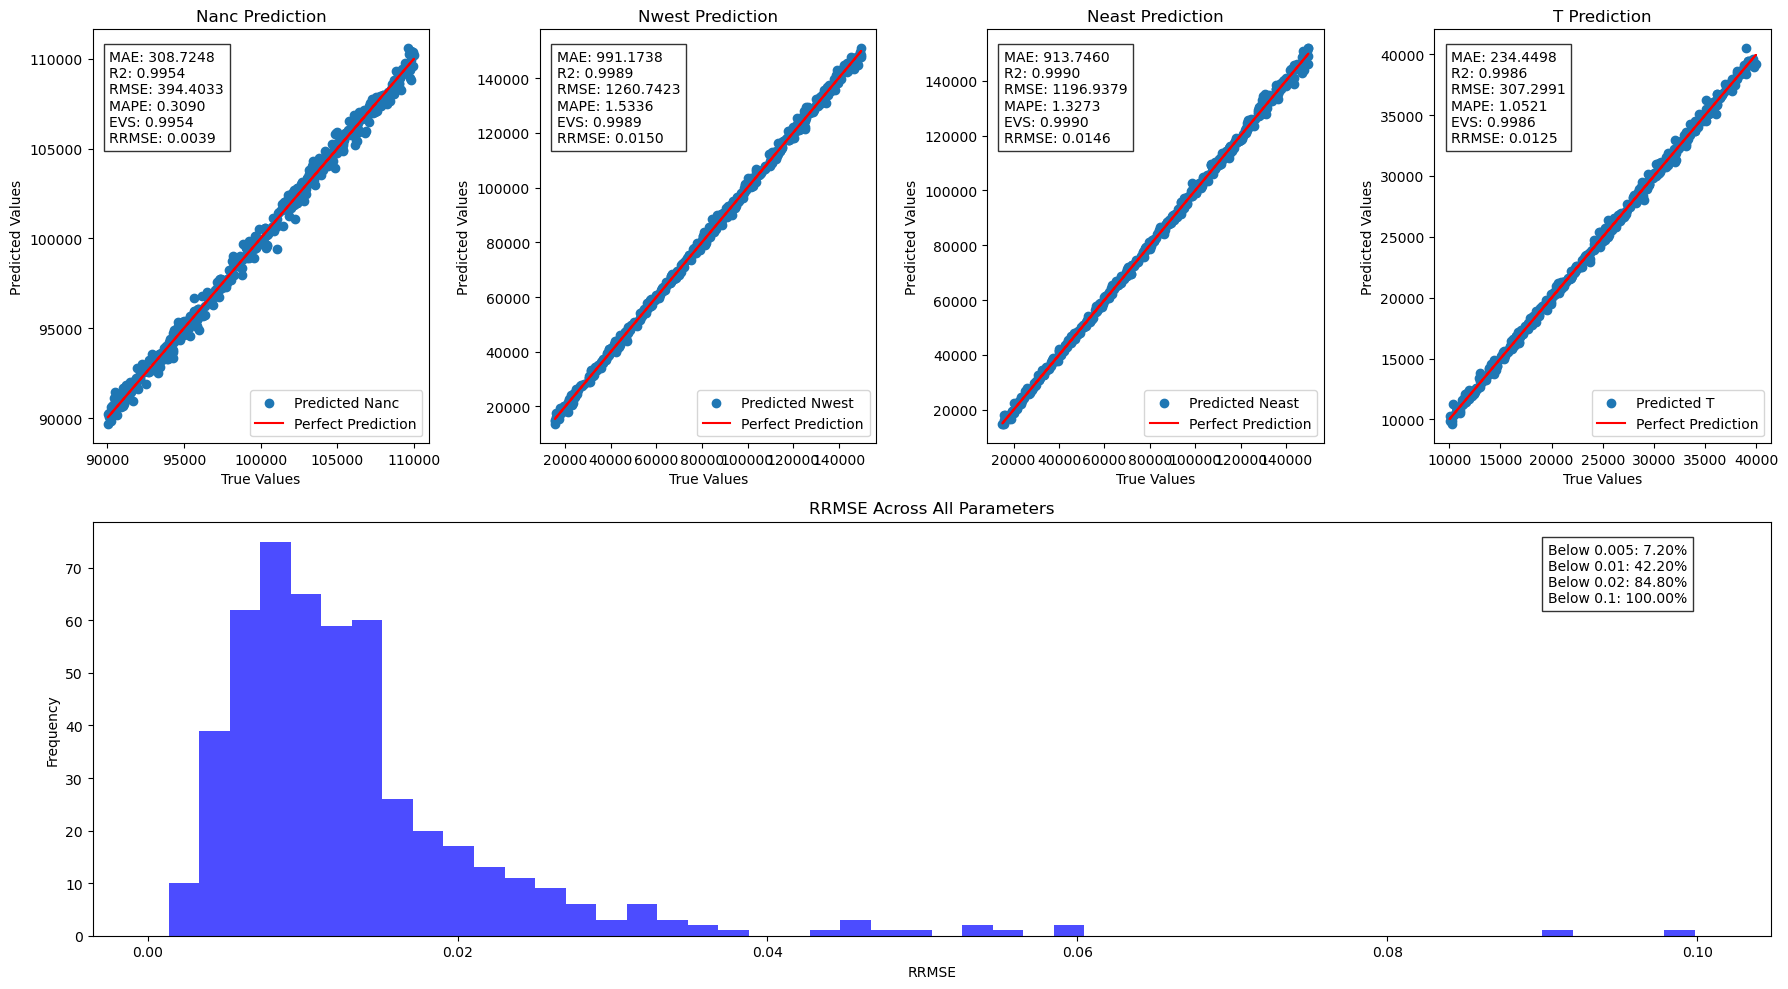

In [9]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

def plot_results_with_rrmse_across_parameters(metrics, all_true_values, all_predicted_means):
    # Create a 2x4 grid layout, with the bottom row merged into one plot for the RRMSE histogram
    fig = plt.figure(figsize=(18, 10))
    gs = gridspec.GridSpec(2, 4, height_ratios=[1, 1])  # Define grid layout with 2 rows, 4 columns
    
    # Plot each parameter individually in the top row
    parameter_names = ["Nanc", "Nwest", "Neast", "T"]
    for i in range(4):
        # Top row: Scatter plot for each parameter
        ax = fig.add_subplot(gs[0, i])
        true_values = all_true_values[:, i]
        predicted_values = all_predicted_means[:, i]
        
        ax.scatter(true_values, predicted_values, label=f'Predicted {parameter_names[i]}')
        ax.plot(true_values, true_values, 'r-', label='Perfect Prediction')  # Line for perfect prediction
        ax.set_title(f'{parameter_names[i]} Prediction')
        ax.set_xlabel('True Values')
        ax.set_ylabel('Predicted Values')
        ax.legend(loc='lower right')
        
        # Display metrics for each parameter
        param_metrics = compute_metrics(true_values.reshape(-1, 1), predicted_values.reshape(-1, 1))
        metrics_text = (
            f'MAE: {param_metrics[0]["mae"]:.4f}\n'
            f'R2: {param_metrics[0]["r2"]:.4f}\n'
            f'RMSE: {param_metrics[0]["rmse"]:.4f}\n'
            f'MAPE: {param_metrics[0]["mape"]:.4f}\n'
            f'EVS: {param_metrics[0]["evs"]:.4f}\n'
            f'RRMSE: {param_metrics[0]["rrmse"]:.4f}'
        )
        ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

    # Bottom: Calculate and plot RRMSE across all parameters
    ax4 = fig.add_subplot(gs[1, :])  # Span the bottom row across all four columns

    # Calculate RRMSE across all parameters per prediction
    rrmse_per_prediction = np.sqrt(np.mean(((all_true_values - all_predicted_means) / all_true_values) ** 2, axis=1))

    # Calculate percentages of RRMSEs below thresholds
    below_005 = np.mean(rrmse_per_prediction < 0.005) * 100
    below_01 = np.mean(rrmse_per_prediction < 0.01) * 100
    below_02 = np.mean(rrmse_per_prediction < 0.02) * 100
    below_1 = np.mean(rrmse_per_prediction < 0.1) * 100

    # Plot the histogram
    ax4.hist(rrmse_per_prediction, bins=50, color='blue', alpha=0.7)
    ax4.set_title('RRMSE Across All Parameters')
    ax4.set_xlabel('RRMSE')
    ax4.set_ylabel('Frequency')

    # Add the calculated percentages as text on the histogram
    percentages_text = (
        f'Below 0.005: {below_005:.2f}%\n'
        f'Below 0.01: {below_01:.2f}%\n'
        f'Below 0.02: {below_02:.2f}%\n'
        f'Below 0.1: {below_1:.2f}%'
    )
    ax4.text(0.95, 0.95, percentages_text, transform=ax4.transAxes, verticalalignment='top', horizontalalignment='right', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    return plt

# Call the function
plot = plot_results_with_rrmse_across_parameters(metrics, true_values, predictions)
plot.show()


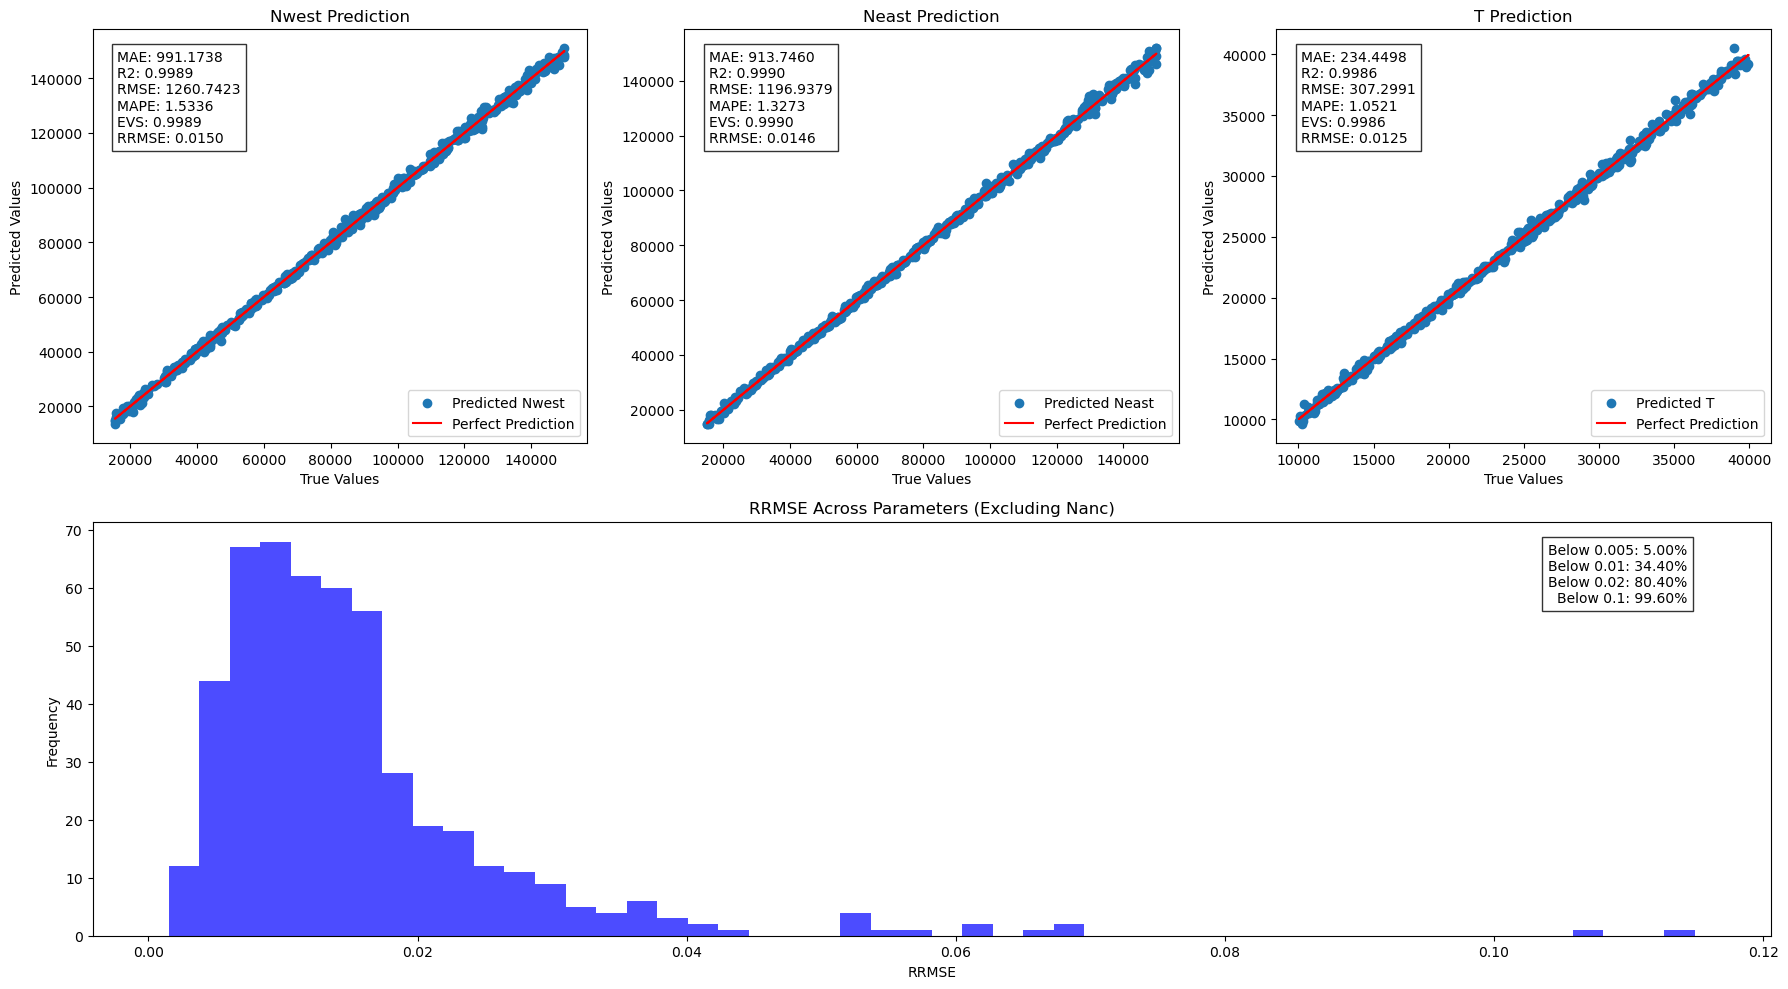

In [10]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

def plot_results_excluding_Nanc(metrics, all_true_values, all_predicted_means):
    # Define parameter names excluding 'Nanc'
    parameter_names = ["Nwest", "Neast", "T"]
    true_values_excluding_Nanc = all_true_values[:, 1:]   # Exclude the first column (Nanc)
    predicted_values_excluding_Nanc = all_predicted_means[:, 1:]  # Exclude the first column (Nanc)

    # Create a 2x3 grid layout, with the bottom row merged into one plot for the RRMSE histogram
    fig = plt.figure(figsize=(18, 10))
    gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1])  # Define grid layout with 2 rows, 3 columns
    
    # Plot each parameter individually in the top row (excluding Nanc)
    for i in range(3):
        # Top row: Scatter plot for each parameter (Nwest, Neast, T)
        ax = fig.add_subplot(gs[0, i])
        true_values = true_values_excluding_Nanc[:, i]
        predicted_values = predicted_values_excluding_Nanc[:, i]
        
        ax.scatter(true_values, predicted_values, label=f'Predicted {parameter_names[i]}')
        ax.plot(true_values, true_values, 'r-', label='Perfect Prediction')  # Line for perfect prediction
        ax.set_title(f'{parameter_names[i]} Prediction')
        ax.set_xlabel('True Values')
        ax.set_ylabel('Predicted Values')
        ax.legend(loc='lower right')
        
        # Display metrics for each parameter
        param_metrics = compute_metrics(true_values.reshape(-1, 1), predicted_values.reshape(-1, 1))
        metrics_text = (
            f'MAE: {param_metrics[0]["mae"]:.4f}\n'
            f'R2: {param_metrics[0]["r2"]:.4f}\n'
            f'RMSE: {param_metrics[0]["rmse"]:.4f}\n'
            f'MAPE: {param_metrics[0]["mape"]:.4f}\n'
            f'EVS: {param_metrics[0]["evs"]:.4f}\n'
            f'RRMSE: {param_metrics[0]["rrmse"]:.4f}'
        )
        ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

    # Bottom: Calculate and plot RRMSE across the selected parameters
    ax4 = fig.add_subplot(gs[1, :])  # Span the bottom row across all three columns

    # Calculate RRMSE across the selected parameters per prediction
    rrmse_per_prediction = np.sqrt(np.mean(((true_values_excluding_Nanc - predicted_values_excluding_Nanc) / true_values_excluding_Nanc) ** 2, axis=1))

    # Calculate percentages of RRMSEs below thresholds
    below_005 = np.mean(rrmse_per_prediction < 0.005) * 100
    below_01 = np.mean(rrmse_per_prediction < 0.01) * 100
    below_02 = np.mean(rrmse_per_prediction < 0.02) * 100

    below_1 = np.mean(rrmse_per_prediction < 0.1) * 100

    # Plot the histogram
    ax4.hist(rrmse_per_prediction, bins=50, color='blue', alpha=0.7)
    ax4.set_title('RRMSE Across Parameters (Excluding Nanc)')
    ax4.set_xlabel('RRMSE')
    ax4.set_ylabel('Frequency')

    # Add the calculated percentages as text on the histogram
    percentages_text = (
        f'Below 0.005: {below_005:.2f}%\n'
        f'Below 0.01: {below_01:.2f}%\n'
        f'Below 0.02: {below_02:.2f}%\n'
        f'Below 0.1: {below_1:.2f}%'
    )
    ax4.text(0.95, 0.95, percentages_text, transform=ax4.transAxes, verticalalignment='top', horizontalalignment='right', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    return plt

# Call the function
plot = plot_results_excluding_Nanc(metrics, true_values, predictions)
plot.show()


In [4]:
from sklearn.metrics import mean_squared_error
import numpy as np

def permutation_feature_importance(model, X_val, y_val, scaler_y, baseline_loss=None, num_repeats=5):
    """
    Calculate permutation feature importance for an MLP model.

    Parameters:
        model: The trained MLP model.
        X_val (numpy.ndarray): Validation features.
        y_val (numpy.ndarray): True validation target values.
        scaler_y: Scaler used for the target variable (to inverse transform predictions).
        baseline_loss (float): Baseline loss with all features intact, if computed before.
        num_repeats (int): Number of times to shuffle each feature for robustness.
    
    Returns:
        importances (dict): Dictionary with features as keys and importance scores as values.
    """
    importances = {}
    y_val_pred = model(torch.tensor(X_val, dtype=torch.float32)).detach().numpy()
    y_val_pred = scaler_y.inverse_transform(y_val_pred)
    y_val_true = scaler_y.inverse_transform(y_val)

    # Calculate baseline loss if not provided
    if baseline_loss is None:
        baseline_loss = mean_squared_error(y_val_true, y_val_pred)
    
    # Iterate over each feature column
    for col in range(X_val.shape[1]):
        feature_name = feature_columns[col]
        losses = []
        
        # Shuffle the column values multiple times for robustness
        for _ in range(num_repeats):
            X_val_permuted = X_val.copy()
            np.random.shuffle(X_val_permuted[:, col])

            # Get model predictions with the permuted column
            y_val_permuted_pred = model(torch.tensor(X_val_permuted, dtype=torch.float32)).detach().numpy()
            y_val_permuted_pred = scaler_y.inverse_transform(y_val_permuted_pred)
            loss = mean_squared_error(y_val_true, y_val_permuted_pred)
            losses.append(loss)
        
        # Calculate the mean increase in loss due to feature permutation
        importances[feature_name] = np.mean(losses) - baseline_loss

    # Sort the importances by descending order
    importances = dict(sorted(importances.items(), key=lambda item: item[1], reverse=True))
    
    return importances

# Usage example:
print(len(X_val_scaled[1]))
feature_importances = permutation_feature_importance(model, X_val_scaled, y_val_scaled, scaler_y)
print("Permutation Feature Importances:", feature_importances)

298


Permutation Feature Importances: {'west_sfs_2': np.float64(21275292.69682877), 'joint_sfs_2': np.float64(20557444.94902205), 'joint_sfs_4': np.float64(18445122.64734776), 'joint_sfs_5': np.float64(15165261.246494474), 'east_sfs_2': np.float64(14141150.22367323), 'east_tajd_mean': np.float64(9630707.808883447), 'west_thetaw_mean': np.float64(9237158.011452023), 'east_sfs_1': np.float64(8697797.906695236), 'east_sfs_3': np.float64(8594673.905953068), 'east_thetaw_median': np.float64(7880466.8602816835), 'east_tajd_median': np.float64(7826441.298096275), 'joint_sfs_6': np.float64(7721782.599113764), 'joint_sfs_3': np.float64(7716826.456980385), 'west_tajd_median': np.float64(7665917.914124832), 'east_thetaw_mean': np.float64(7472228.088808083), 'west_tajd_mean': np.float64(7035046.6037508985), 'west_sfs_3': np.float64(6427987.814936882), 'west_thetaw_median': np.float64(5601316.553280618), 'east_west_fst_weir_cockerham_mean': np.float64(5489398.329298283), 'east_west_fst_hudson_mean': np.

In [5]:
def gradient_feature_importance(model, X_val_tensor):
    """
    Calculate gradient-based feature importance for an MLP model.

    Parameters:
        model: The trained MLP model.
        X_val_tensor (torch.Tensor): Validation features as a PyTorch tensor.
    
    Returns:
        importances (dict): Dictionary with features as keys and average gradient magnitudes as values.
    """
    model.eval()
    X_val_tensor.requires_grad = True  # Enable gradient tracking on the input

    # Get model predictions
    y_pred = model(X_val_tensor)
    
    # Calculate gradients with respect to the input
    y_pred.sum().backward()  # Summing the output makes it easier to calculate gradients

    # Compute mean of absolute gradients for each feature
    importances = X_val_tensor.grad.abs().mean(dim=0).detach().numpy()
    
    # Map feature names to their importance scores
    importance_dict = dict(zip(feature_columns, importances))
    importance_dict = dict(sorted(importance_dict.items(), key=lambda item: item[1], reverse=True))
    
    return importance_dict

# Usage example:
grad_importances = gradient_feature_importance(model, X_val_tensor)
print("Gradient-Based Feature Importances:", grad_importances)

Gradient-Based Feature Importances: {'joint_sfs_2': np.float32(0.19427095), 'west_sfs_2': np.float32(0.17726232), 'east_num_variants': np.float32(0.13929209), 'east_sfs_2': np.float32(0.13771497), 'joint_thetaw_median': np.float32(0.12626901), 'west_num_variants': np.float32(0.120242044), 'joint_num_variants': np.float32(0.119424336), 'joint_thetaw_mean': np.float32(0.11036442), 'east_tajd_mean': np.float32(0.09948215), 'joint_tajd_mean': np.float32(0.0977572), 'east_thetaw_mean': np.float32(0.09509515), 'east_sfs_3': np.float32(0.09343519), 'west_sfs_8': np.float32(0.09335145), 'west_sfs_6': np.float32(0.093240716), 'west_sfs_10': np.float32(0.08678492), 'west_sfs_7': np.float32(0.08672402), 'east_tajd_median': np.float32(0.08625371), 'east_thetaw_median': np.float32(0.084964946), 'joint_sfs_4': np.float32(0.083479196), 'west_tajd_mean': np.float32(0.08166578), 'west_thetaw_mean': np.float32(0.08074632), 'joint_sfs_5': np.float32(0.07728221), 'west_sfs_11': np.float32(0.07609244), 'we

In [6]:
# Number of top features to display
top_n = 10

# Create DataFrames from the importance dictionaries
perm_importance_df = pd.DataFrame(list(feature_importances.items()), columns=['Feature', 'Permutation Importance'])
grad_importance_df = pd.DataFrame(list(grad_importances.items()), columns=['Feature', 'Gradient-Based Importance'])

# Merge both DataFrames on 'Feature'
importance_df = pd.merge(perm_importance_df, grad_importance_df, on='Feature', how='inner')

# Sort by permutation importance and get top n features
top_features_df = importance_df.sort_values(by='Permutation Importance', ascending=False).head(top_n)

print("Top Features by Importance:")
print(top_features_df)

# Convert DataFrame to markdown-style table manually
markdown_table = "| Feature | Permutation Importance | Gradient-Based Importance |\n"
markdown_table += "|---------|------------------------|---------------------------|\n"

# Iterate through each row to add it to the table
for _, row in top_features_df.iterrows():
    markdown_table += f"| {row['Feature']} | {row['Permutation Importance']} | {row['Gradient-Based Importance']} |\n"

print(markdown_table)

Top Features by Importance:
              Feature  Permutation Importance  Gradient-Based Importance
0          west_sfs_2            2.127529e+07                   0.177262
1         joint_sfs_2            2.055744e+07                   0.194271
2         joint_sfs_4            1.844512e+07                   0.083479
3         joint_sfs_5            1.516526e+07                   0.077282
4          east_sfs_2            1.414115e+07                   0.137715
5      east_tajd_mean            9.630708e+06                   0.099482
6    west_thetaw_mean            9.237158e+06                   0.080746
7          east_sfs_1            8.697798e+06                   0.060258
8          east_sfs_3            8.594674e+06                   0.093435
9  east_thetaw_median            7.880467e+06                   0.084965
| Feature | Permutation Importance | Gradient-Based Importance |
|---------|------------------------|---------------------------|
| west_sfs_2 | 21275292.69682877 | 0.17

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch

# Assuming the following variables are already defined:
# plot_dir, top_features_df, df, parameter_columns, feature_columns, scaler_X, scaler_y, model

# Load the target stats file with only feature columns (not parameters)
target_stats_path = '/nas/longleaf/home/adaigle/work/ghist_2024_work/split_hugepriors/split2/target/target.stats'
target_df = pd.read_csv(target_stats_path, sep='\t')

print("First few rows of target_df:")
print(target_df.head())

print("Columns in target_df:", target_df.columns)
print("Data types in target_df:", target_df.dtypes)

print("Values in joint_sfs_3 and joint_sfs_4:")
print(target_df["joint_sfs_3"].head())
print(target_df["joint_sfs_4"].head())

# Extract only feature columns
target_features = target_df[feature_columns].values

# Scale the target features
target_features_scaled = scaler_X.transform(target_features)
target_features_tensor = torch.tensor(target_features_scaled, dtype=torch.float32)

# Predict parameter values for the target stats
model.eval()
with torch.no_grad():
    target_predictions_scaled = model(target_features_tensor).numpy()

# Inverse transform to get predictions in the original scale
target_predictions = scaler_y.inverse_transform(target_predictions_scaled)

# Create a DataFrame for predictions with the target names as columns
target_predictions_df = pd.DataFrame(target_predictions, columns=parameter_columns)

# Verify the predictions
print("Target Predictions:")
print(target_predictions_df.head())

# Create a directory for plots if it doesn't exist
os.makedirs(plot_dir, exist_ok=True)

# Plot top features against each target variable
for feature in top_features_df['Feature']:
    if feature not in df.columns:
        print(f"Feature '{feature}' not found in the DataFrame 'df'. Skipping.")
        continue
    for target_name in parameter_columns:
        if target_name not in df.columns:
            print(f"Target '{target_name}' not found in the DataFrame 'df'. Skipping.")
            continue
        
        plt.figure(figsize=(8, 6))
        
        # Scatter plot of the existing data
        plt.scatter(df[feature], df[target_name], alpha=0.6, label="Data")
        
        # Retrieve the feature value from target_df for plotting the prediction
        feature_value = target_df.at[0, feature]  # Assuming single row in target_df
        predicted_target = target_predictions_df.at[0, target_name]
        
        print(f"Plotting Feature: {feature}, Target: {target_name}")
        print(f"Feature value from target_df: {feature_value}")
        print(f"Predicted target value: {predicted_target}")
        
        # Scatter plot of the predicted target point (bright red 'x')
        plt.scatter(feature_value, predicted_target, color='red', marker='x', s=100, label="Prediction")
        
        # Add plot title and labels
        plt.title(f"{feature} vs {target_name}")
        plt.xlabel(feature)
        plt.ylabel(target_name)
        plt.legend()
        
        # Save each plot
        plot_filename = os.path.join(plot_dir, f"{feature}_vs_{target_name}.png")
        plt.savefig(plot_filename)
        plt.close()
        print(f"Plot saved to {plot_filename}")


First few rows of target_df:
   joint_thetapi_mean  joint_thetapi_median  joint_thetapi_sd  \
0            0.002249              0.002243            0.0002   

   joint_thetapi_iqr  joint_hprime_mean  joint_hprime_median  joint_hprime_sd  \
0           0.000265           -0.04998            -0.035493         0.183428   

   joint_hprime_iqr  joint_thetaw_mean  joint_thetaw_median  ...  \
0          0.223644           0.002379             0.002382  ...   

   west_ld_decay_550bp  west_ld_decay_650bp  west_ld_decay_750bp  \
0             0.353528             0.343339              0.33915   

   west_ld_decay_850bp  west_ld_decay_950bp  west_num_samples  \
0             0.343325             0.388571                18   

   west_num_variants  east_west_fst_hudson_mean  \
0            1178075                   0.160612   

   east_west_fst_weir_cockerham_mean  east_west_f2_mean  
0                            0.15835            0.03293  

[1 rows x 298 columns]
Columns in target_df: Index([

In [16]:
def permutation_importance_per_target(model, X_val, y_val, scaler_y, target_names, num_repeats=5):
    """
    Calculate permutation feature importance separately for each target variable.
    
    Parameters:
        model: Trained MLP model.
        X_val (numpy.ndarray): Validation features.
        y_val (numpy.ndarray): True validation target values.
        scaler_y: Scaler for the target variable.
        target_names (list): List of target parameter names.
        num_repeats (int): Number of times to shuffle each feature for robustness.
    
    Returns:
        importances (dict): Dictionary where keys are target names and values are dictionaries
                            of feature importances for each target.
    """
    importances = {target: {} for target in target_names}
    y_val_true = scaler_y.inverse_transform(y_val)

    # Predict for all targets with unshuffled data to get baseline performance
    y_val_pred = model(torch.tensor(X_val, dtype=torch.float32)).detach().numpy()
    y_val_pred = scaler_y.inverse_transform(y_val_pred)
    baseline_losses = [mean_squared_error(y_val_true[:, i], y_val_pred[:, i]) for i in range(y_val_true.shape[1])]
    
    # Loop over each feature column
    for col in range(X_val.shape[1]):
        feature_name = feature_columns[col]
        
        # Shuffle the column values multiple times and compute the loss increase per target
        for target_idx, target_name in enumerate(target_names):
            losses = []
            for _ in range(num_repeats):
                X_val_permuted = X_val.copy()
                np.random.shuffle(X_val_permuted[:, col])

                # Get model predictions with the permuted column
                y_val_permuted_pred = model(torch.tensor(X_val_permuted, dtype=torch.float32)).detach().numpy()
                y_val_permuted_pred = scaler_y.inverse_transform(y_val_permuted_pred)
                
                # Calculate loss for the specific target variable
                loss = mean_squared_error(y_val_true[:, target_idx], y_val_permuted_pred[:, target_idx])
                losses.append(loss)

            # Calculate mean importance for this feature on this target
            importances[target_name][feature_name] = np.mean(losses) - baseline_losses[target_idx]

    return importances

# Usage example:
target_importances_perm = permutation_importance_per_target(model, X_val_scaled, y_val_scaled, scaler_y, parameter_columns)
print("Permutation Feature Importances per Target:")
for target, feature_importances in target_importances_perm.items():
    sorted_importances = sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)
    print(f"Target: {target}")
    for feature, importance in sorted_importances[:10]:  # Display top 10 features per target
        print(f"  Feature: {feature}, Importance: {importance:.4f}")

Permutation Feature Importances per Target:
Target: Nanc
  Feature: ld_decay_250bp, Importance: 469568.5274
  Feature: thetaw_sd, Importance: 455333.6685
  Feature: tajd_mean, Importance: 428576.6058
  Feature: tajd_sd, Importance: 411860.6555
  Feature: ld_decay_750bp, Importance: 298325.6976
  Feature: ld_decay_550bp, Importance: 287775.6961
  Feature: ld_decay_50bp, Importance: 271989.8076
  Feature: ld_decay_950bp, Importance: 179445.4786
  Feature: hprime_sd, Importance: 159166.5152
  Feature: thetapi_sd, Importance: 152112.6915
Target: N0
  Feature: number_of_haplotypes_mean, Importance: 1155392.2902
  Feature: number_of_haplotypes_median, Importance: 421411.7307
  Feature: sfs_2, Importance: 263054.8362
  Feature: haplotype_diversity_median, Importance: 127668.5568
  Feature: sfs_3, Importance: 117578.2081
  Feature: haplotype_diversity_mean, Importance: 99361.6178
  Feature: haplotype_diversity_iqr, Importance: 52196.9251
  Feature: thetaw_mean, Importance: 49067.6141
  Feature

In [17]:
def gradient_importance_per_target(model, X_val_tensor, target_names):
    """
    Calculate gradient-based feature importance separately for each target variable.
    
    Parameters:
        model: Trained MLP model.
        X_val_tensor (torch.Tensor): Validation features as a PyTorch tensor.
        target_names (list): List of target parameter names.
    
    Returns:
        importances (dict): Dictionary where keys are target names and values are dictionaries
                            of feature importances for each target.
    """
    model.eval()
    X_val_tensor.requires_grad = True

    # Dictionary to hold the importance for each target
    importances = {target: {} for target in target_names}

    # Loop over each target parameter
    for target_idx, target_name in enumerate(target_names):
        model.zero_grad()  # Reset gradients for each target
        y_pred = model(X_val_tensor)[:, target_idx].sum()  # Focus on one target at a time
        y_pred.backward()  # Compute gradients with respect to input
        
        # Get mean absolute gradients for each feature for this specific target
        abs_gradients = X_val_tensor.grad.abs().mean(dim=0).detach().numpy()
        
        # Store feature importances for this target
        for feature_idx, feature_name in enumerate(feature_columns):
            importances[target_name][feature_name] = abs_gradients[feature_idx]
        
        # Clear gradients after each target
        X_val_tensor.grad.zero_()

    # Sort importances for each target by value
    for target in importances:
        importances[target] = dict(sorted(importances[target].items(), key=lambda item: item[1], reverse=True))
    
    return importances

# Usage example:
target_importances_grad = gradient_importance_per_target(model, X_val_tensor, parameter_columns)
print("Gradient-Based Feature Importances per Target:")
for target, feature_importances in target_importances_grad.items():
    print(f"Target: {target}")
    for feature, importance in list(feature_importances.items())[:10]:  # Top 10 features per target
        print(f"  Feature: {feature}, Importance: {importance:.4f}")

Gradient-Based Feature Importances per Target:
Target: Nanc
  Feature: number_of_haplotypes_mean, Importance: 2.4157
  Feature: number_of_haplotypes_median, Importance: 1.0916
  Feature: haplotype_diversity_mean, Importance: 0.9098
  Feature: haplotype_diversity_median, Importance: 0.8693
  Feature: ld_decay_250bp, Importance: 0.8547
  Feature: ld_decay_50bp, Importance: 0.7404
  Feature: ld_decay_550bp, Importance: 0.6866
  Feature: tajd_mean, Importance: 0.6456
  Feature: ld_decay_950bp, Importance: 0.6062
  Feature: ld_decay_150bp, Importance: 0.5794
Target: N0
  Feature: number_of_haplotypes_mean, Importance: 1.2498
  Feature: number_of_haplotypes_median, Importance: 0.6051
  Feature: haplotype_diversity_median, Importance: 0.4989
  Feature: haplotype_diversity_mean, Importance: 0.4022
  Feature: sfs_2, Importance: 0.3419
  Feature: haplotype_diversity_iqr, Importance: 0.2770
  Feature: sfs_3, Importance: 0.2046
  Feature: haplotype_diversity_sd, Importance: 0.2025
  Feature: tajd_

In [19]:
# Convert dictionaries to DataFrames and format for presentation
perm_importances_df = pd.DataFrame(target_importances_perm).fillna(0)
grad_importances_df = pd.DataFrame(target_importances_grad).fillna(0)

# Combine the two tables for easy comparison
combined_importances_df = pd.concat([perm_importances_df, grad_importances_df], axis=1, keys=["Permutation", "Gradient"])
print("Combined Feature Importance Summary Table:")
print(combined_importances_df.head(100))  # Display top 10 rows

Combined Feature Importance Summary Table:
                 Permutation                              Gradient            \
                        Nanc            N0            N1      Nanc        N0   
thetapi_mean    9.466712e+03    742.696537  2.526765e+03  0.130984  0.036254   
thetapi_median  1.635823e+04    795.439366  2.331450e+03  0.152218  0.033082   
thetapi_sd      1.521127e+05    514.404649  1.103289e+03  0.268722  0.030161   
thetapi_iqr     5.263449e+03    689.197065  5.853924e+02  0.088164  0.031711   
hprime_mean     1.507401e+05   1332.411342  3.497974e+02  0.318654  0.034492   
...                      ...           ...           ...       ...       ...   
ld_decay_750bp  2.983257e+05    359.335632  2.059449e+03  0.549245  0.029146   
ld_decay_850bp  1.086765e+05   2624.470745  2.402296e+03  0.426556  0.057872   
ld_decay_950bp  1.794455e+05   9342.153245  2.733089e+03  0.606237  0.085980   
num_samples    -1.455192e-11      0.000000  2.273737e-13  0.101971  0.064474 